# Quel effet de l'encadrement des loyers sur les prix de l'immobilier ? 


# Introduction 

Ce projet Python s'inscrit dans le cadre du débat public existant autour de l'efficacité économique de l'instauration de l'encadrement des loyers dans certaines agglomérations (Paris, Lyon, Bordeaux...) considérées comme "zones tendues". Ces villes sont en effet caractérisées par un déséquilibre entre offre et demande de logements ainsi qu'un prix des loyers croissant. 
Dans un [article publié en 2019 dans _American Economic Review_](https://www.aeaweb.org/articles?id=10.1257/aer.20181289) , des chercheurs de l'Université de Stanford ont modélisé les effets de l'introduction d'un contrôle des loyers à San Francisco dans les années 1990. Leurs recherches démontrent que cette mesure n'est pas sans conséquence économique sur le parc immobilier de la ville. Elle est en effet à l'origine une forte baisse de l'offre locative mais également d'une mobilité des habitants moindre avec un renouvellement résidentiel plus faible du parc locatif.

Quel est alors l'effet de l'encadrement des loyers sur les prix de l'immobilier ? 

L'objectif principal de notre travail est également d'étudier plus largement, à partir de la base de données DVF (demandes de valeurs foncières) et de deux bases de l'Insee (celle du recensement et celle des données administratives sur les revenus, appelée Filosofi), les effets de cette politique du logement, très souvent discutée dans le débat politique, sur l'évolution des prix moyens et médians d'achat et l'offre de transactions immobilières. En effet, la relation entre encadrement des loyers et évolution des tendances sur le marché immobilier semble relativement complexe et dépendante de nombreux facteurs sociaux, économiques et politiques. On peut en effet supposer que du fait de la réduction des revenus locatifs engendrée par l'encadrement des loyers, les investisseurs anticipent des rendements plus faibles et sont donc moins enclins à acheter des biens immobiliers, ce qui pourrait réduire les prix ou du moins réduire leur vitesse d'accroissement. Par ailleurs, il est également possible d'émettre l'hypothèse que les investisseurs se reportent alors vers des zones non soumises à encadrement, augmentant alors potentiellement la demande et le prix dans ces zones.  

Par l'application d'un modèle "difference-in-difference" sur différentes zones géographiques soumises et non soumises à l'encadrement des loyers et la réalisation de statistiques descriptives, nous souhaitons donc voir s'il est possible de véritablement mesurer ces évolutions et finalement d'infirmer ou confirmer ces hypothèses aux effets contraires en identifiant les effets de l'encadrement des loyers sur les prix de l'immobilier. 

## Installation et préparation

In [1]:
!pip install py7zr geojson geopandas openpyxl tqdm s3fs
!pip install PyYAML xlrd

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import geojson
import requests
import time
import os
import re
import matplotlib.pyplot as plt
import zipfile
import folium
from folium.plugins import MarkerCluster
from io import StringIO
import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from functions import cleaning_json_for_gpd
from functions import recup_donnees_dvf_all_years
import seaborn as sns

# I. Importation, fusion et nettoyage de nos données

Notre travail réunit 3 bases de données différentes, importées et traitées dans les parties A à C qui suivent :
- Les données de la base DVF (demande de valeur foncière) (partie I.A.) : cette base contient des données basiques sur les caractéristiques de tous les biens immobiliers vendus en France, notamment leur prix, le nombre de mètre carré et leur emplacement.
- les données par IRIS de l'Insee (I.B.) : un IRIS ("îlots regroupés pour l'information statistique") est une zone géographique d'environ 2000 habitants ; le découpage des IRIS a été fait par l'Insee et permet de fournir des informations détaillés par quartier à partir des différentes enquêtes de l'Insee (ici, la base administrative de revenu Filosofi et le recensement de la population)
- les données géographiques des IRIS de toute l'île-de-France (I.C.). On va en effet se concentrer sur l'Île-de-France. Cette base permettra d'apparier toutes les ventes en Île-de-France de la base DVF à leur IRIS, et donc de connaître les caractéristiques du quartier où se situe le bien immobilier vendu. 

### I.A. Importation des données DVF

On commence d'abord par paramétrer l'API pour pouvoir importer les données DVF, en définissant le lien vers l'API du Cerema (organisme gérant ces données).

In [3]:
base_api_dvf_url = "https://apidf-preprod.cerema.fr"
global base_api_dvf_url

On souhaite réaliser notre étude comparative sur deux zones : l'ouest et le sud parisien. Dans chaque zone, on a besoin d'un groupe traitement, i.e. celui où il y a eu encadrement des loyers, c'est-à-dire les arrondissements parisiens. On a aussi besoin d'un groupe contrôle, c'est-à-dire qui n'a pas connu d'encadrement des loyers, de préférence le plus similaire au groupe traitement. On choisit pour cela les villes de banlieues immédiatement contiguës aux arrondissements. Au total, on souhaite donc récupérer les données de la base DVF des villes suivantes : 

1. **Zone ouest** :
- Paris 16 : 75116
- Paris 17: 75117 
- Clichy : 92024
- Levallois : 92044
- Neuilly : 92051
- Boulogne-Billancourt : 92012

2. **Zone sud**
- Paris 13 : 75113
- Paris 14 : 75114
- Paris 15 : 75115
- Issy-les-Moulineaux : 92040
- Vanves : 92075
- Malakoff : 92046
- Montrouge : 92049
- Gentilly : 94037
- Ivry-sur-Seine : 94041

Pour information, l'encadrement des loyers s'applique à Paris depuis le 1er juillet 2019, tandis que les villes de banlieues parisiennes mentionnées ci-dessus ne sont pas concernées.

On a exploré le fonctionnement de l'API pour une ville (Issy-les-Moulineaux, de code Insee 92040) avec le code ci-dessous (ne pas hésiter à relancer le code s'il est trop long à s'exécuter, il est censé s'exécuter très rapidement).

In [4]:
#On écrit l'url complète de la requête
code_insee = 92040
url = base_api_dvf_url + f"/dvf_opendata/geomutations/?code_insee={code_insee}&page_size=500"

#On requête et on regarde la réponse
response = requests.get(url)
data = response.json()
print(data)

#On regarde le geodataframe obtenu
cleaning_json_for_gpd(data)
mut_gdf = gpd.GeoDataFrame.from_features(data["features"])
print(len(mut_gdf))

{'type': 'FeatureCollection', 'count': 11307, 'next': 'http://apidf-preprod.cerema.fr/dvf_opendata/geomutations/?code_insee=92040&page=2&page_size=500', 'previous': None, 'features': [{'id': 12592219, 'type': 'Feature', 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[2.265136, 48.826519], [2.264991, 48.826444], [2.26498, 48.826439], [2.264965, 48.826431], [2.264933, 48.826415], [2.264954, 48.826396], [2.264956, 48.826395], [2.26497, 48.826383], [2.264975, 48.826379], [2.265068, 48.826299], [2.265072, 48.826295], [2.265081, 48.826288], [2.265087, 48.826282], [2.265058, 48.826267], [2.265003, 48.826239], [2.264966, 48.826221], [2.264938, 48.826206], [2.264912, 48.826193], [2.264882, 48.826178], [2.264885, 48.826176], [2.264905, 48.826158], [2.26489, 48.826156], [2.26484, 48.826149], [2.264802, 48.826144], [2.264745, 48.826136], [2.264741, 48.826135], [2.26472, 48.826132], [2.26469, 48.826128], [2.264657, 48.826123], [2.264647, 48.826122], [2.264981, 48.825864], [2.265609, 48.8259

On constate en faisant tourner naïvement l'API qu'on obtient toujours des données par paquets en nombre limité (par défaut, 100). On peut modifier cela par le paramètre "page_size", mais la limite est de 500. Pour un paramètre supérieur à 500, on n'obtient que des pages de 500. 

On cherche donc à faire boucler nos requêtes à l'API jusqu'à obtenir toutes les données concernant la commune qui nous intéresse. Or on constate que la réponse "data" que l'on obtient possède une clé "next", qui donne l'url de notre requête complété par un argument "page". L'API fonctionne donc ainsi : s'il y a plus de 500 observations pour une commune, l'API nous renvoie une première page qui contient 500 observations, avec l'url pour requêter la page suivant qui contient 500 autres observations, et ainsi de suite jusqu'à la dernière page, qui donne pour valeur "None" à la clé "next". 

Le code ci-dessous permet théoriquement de récupérer les données pour toutes les villes et arrondissement de la zone sud. 
Cependant, comme l'API semble très souvent mal répondre à nos requêtes, cette boucle ne s'exécute quasiment jamais sans erreur ; nous l'avons laissé dans le notebook pour montrer la boucle qu'il aurait fallu en théorie faire pour le cluster sud (et qui devrait fonctionner si l'API répondait toujours correctement), et nous expliquons plus loin comment nous avons fait en pratique pour récupérer les données.

In [5]:
data_dvf_sud = recup_donnees_dvf_all_years(base_api_dvf_url,"92040") 

code_insee_sud = ["92075", "92046", "92049", "94037", "94041", "75113", "75114", "75115"]

for code_insee_ville in code_insee_sud: 
    print(code_insee_ville)
    data_temp = recup_donnees_dvf_all_years(base_api_dvf_url,code_insee_ville)
    data_dvf_sud = pd.concat([data_dvf_sud, data_temp], axis = 0)

data_dvf_sud.shape

http://apidf-preprod.cerema.fr/dvf_opendata/geomutations/?code_insee=92040&page=2&page_size=500
http://apidf-preprod.cerema.fr/dvf_opendata/geomutations/?code_insee=92040&page=3&page_size=500
http://apidf-preprod.cerema.fr/dvf_opendata/geomutations/?code_insee=92040&page=4&page_size=500
http://apidf-preprod.cerema.fr/dvf_opendata/geomutations/?code_insee=92040&page=5&page_size=500
http://apidf-preprod.cerema.fr/dvf_opendata/geomutations/?code_insee=92040&page=6&page_size=500
http://apidf-preprod.cerema.fr/dvf_opendata/geomutations/?code_insee=92040&page=7&page_size=500
http://apidf-preprod.cerema.fr/dvf_opendata/geomutations/?code_insee=92040&page=8&page_size=500
http://apidf-preprod.cerema.fr/dvf_opendata/geomutations/?code_insee=92040&page=9&page_size=500
http://apidf-preprod.cerema.fr/dvf_opendata/geomutations/?code_insee=92040&page=10&page_size=500
http://apidf-preprod.cerema.fr/dvf_opendata/geomutations/?code_insee=92040&page=11&page_size=500
http://apidf-preprod.cerema.fr/dvf_ope

KeyboardInterrupt: 

On pourrait écrire la même chose pour la zone ouest, mais comme expliqué précédemment, l'API peut arrêter de nous répondre de manière imprévue au milieu de la boucle de requête des pages. Dans ce cas, toutes les données obtenues sur les pages précédentes sont perdues. On a donc intérêt, pour épargner au correcteur et aux étudiants de très nombreuses exécutions de cette cellule, à télécharger ces données toujours grâce à l'API mais ville par ville.  

Pour ce faire, on va essayer, commune par commune, de requêter toutes les pages, et, AVANT de passer au requêtage pour la commune suivante, on sauvegarde notre geodataframe au format geojson. On inscrit donc le code INSEE de toutes les communes dont on veut récupérer les données dans la liste "code_insee_pour_enregistrer", et à chaque fois qu'un fichier pour une commune est téléchargé, on supprime son code INSEE de la liste. 

On propose ici un exemple avec uniquement le code INSEE 92012 dans la liste des villes d'intérêt, pour que le correcteur puisse vérifier que le code fonctionne s'il le souhaite ; si jamais le code cesse de "printer" des lignes pendant longtemps, c'est probablement que l'API a cessé de répondre et qu'il faut relancer la cellule. On sait que l'API a bien répondu lorsque None s'affiche à la toute fin de l'exécution de la fausse boucle ci-dessous. 

In [11]:
code_insee_pour_enregistre = ["92024"]
for code_insee in code_insee_pour_enregistre: 
    url = base_api_dvf_url + f"/dvf_opendata/geomutations/?code_insee={code_insee}&page_size=100"
    response = requests.get(url)
    data = response.json()
    print(data['count'])
    gdf = recup_donnees_dvf_all_years(base_api_dvf_url,code_insee)
    name = f'data/dvf/cluster_ouest/data_code_insee={code_insee}.geojson'
    gdf.to_file(name, driver="GeoJSON")
    gdf = gpd.read_file(name)
    print(len(gdf))

11152
http://apidf-preprod.cerema.fr/dvf_opendata/geomutations/?code_insee=92024&page=2&page_size=500
http://apidf-preprod.cerema.fr/dvf_opendata/geomutations/?code_insee=92024&page=3&page_size=500
http://apidf-preprod.cerema.fr/dvf_opendata/geomutations/?code_insee=92024&page=4&page_size=500
http://apidf-preprod.cerema.fr/dvf_opendata/geomutations/?code_insee=92024&page=5&page_size=500
http://apidf-preprod.cerema.fr/dvf_opendata/geomutations/?code_insee=92024&page=6&page_size=500
http://apidf-preprod.cerema.fr/dvf_opendata/geomutations/?code_insee=92024&page=7&page_size=500
http://apidf-preprod.cerema.fr/dvf_opendata/geomutations/?code_insee=92024&page=8&page_size=500
http://apidf-preprod.cerema.fr/dvf_opendata/geomutations/?code_insee=92024&page=9&page_size=500
http://apidf-preprod.cerema.fr/dvf_opendata/geomutations/?code_insee=92024&page=10&page_size=500
http://apidf-preprod.cerema.fr/dvf_opendata/geomutations/?code_insee=92024&page=11&page_size=500
http://apidf-preprod.cerema.fr/d

/opt/conda/lib/python3.12/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


11152


Ci-dessous se trouve le code pour reconstituer les fichiers geojson à partir des sauvegardes faites précédemment par les étudiants à cause de l'API répondant mal (en deux temps : la zone ouest puis la zone sud).

In [12]:
#On crée une variable pour être sûrs qu'on concatène bien les dataframe
obs_tot = 0

#On crée un liste où on va mettre tous les dataframes
list_gpd_ouest = []

#On boucle pour importer tous les fichiers dans cette liste, en comptant à chaque fois le nombre d'observation
#du dataframe ouvert
for geo_file in os.listdir("data/dvf/cluster_ouest"): 
    geo_file_temp = gpd.read_file("data/dvf/cluster_ouest/"+geo_file)  
    list_gpd_ouest.append(geo_file_temp)
    obs_tot += len(geo_file_temp)

#On concatène tous les dataframes de la liste
all_gpd_ouest = pd.concat(list_gpd_ouest)

#On vérifie que le dataframe obtenu a autant d'observations que la somme de tous ceux qu'on a ouvert
print(len(all_gpd_ouest), obs_tot)

134410 134410


In [13]:
#Idem pour le Sud
obs_tot = 0
list_gpd_sud = []
for geo_file in os.listdir("data/dvf/cluster_sud"): 
    geo_file_temp = gpd.read_file("data/dvf/cluster_sud/"+geo_file)  
    obs_tot += len(geo_file_temp)
    list_gpd_sud.append(geo_file_temp)

all_gpd_sud = pd.concat(list_gpd_sud)
print(len(all_gpd_sud), obs_tot) 

119319 119319


L'importation des données DVF est donc terminée.

### I.B. Récupération de données Insee par IRIS pour avoir des variables de contrôle dans notre régression

Il n'y a pas d'API permettant de récupérer les données voulues par IRIS, donc on doit passer par l'importation manuelle de tous les fichiers, que l'on stocke dans "data/insee" pour un accès facile par tous les utilisateurs du dépôt Github. On importe trois types de fichiers : un qui contient des informations sur le revenu disponible ('BASE_TD_FILO_DISP_IRIS') issues de la base de données administratives Filosofi, un qui donne des informations sur les logements ('base_ic_logement') et un sur les occupations professionnelles des habitants de l'IRIS ('base-ic-activite-residents'), toutes deux provenant des données du recensement. 

On va maintenant ouvrir et déjà faire quelques traitements sur tous ces fichiers importés. Cette importation et traitement sont lourds en raison de la multiplicité des formats : les fichiers Insee peuvent être sous forme de fichier zip ou non (d'où une première boucle) ; dans le cas des zip, le zip contient deux fichiers, l'un avec les données et l'autre avec les métadonnées (d'où une deuxième boucle)
Ces fichiers ont globalement la même structure mais pas exactement, justifiant ainsi d'autres tests de condition sous forme de if-else pour faire le bon traitement

Attention, l'exécution de cette cellule prend 1m30 à 3 minutes en raison de l'importation de fichiers lourds : la commande "print" dans la boucle permet de s'assurer que la boucle continue de tourner grâce à l'affichage régulier d'un nouveau nom de fichier. 

In [14]:
dfs_activite = []
dfs_logement = []
dfs_revenu = []
dates_df = []


for f in os.listdir("data/insee"):
    if f.lower().endswith(".zip"): #si le fichier c'est un zip
        print(f)
        zip_file = zipfile.ZipFile("data/insee/"+f) #on le dézipe
        nom_racine_dossier = f.rsplit(".",1)[0] #on récupère le nom du fichier sans l'extension .zip
        for f_in_zip in zipfile.ZipFile("data/insee/"+f).namelist(): #on parcourt les fichies présents dans les zips
            if f_in_zip[0:4] == "meta" : 
                pass #on ignore les fichiers de métadonnées
            else :
                nom_racine_fichier = f_in_zip.rsplit(".",1)[0] #on récupère le nom du fichier contenant les données
                extension = f_in_zip.rsplit(".",1)[1] #on récupère l'extension du fichier en question
                
                # Recherche de l'année
                schema_date = r"(\d{4})" 
                match = re.search(schema_date, f) #on identifie l'année correspondant au jeu de données
                annee_extraite = match.group(1)
                
                #ci-dessous, deux traitements selon le type du fichier (csv ou excel)
                if extension.lower() == "csv": 
                    df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension), 
                                            sep = ";", dtype = {'IRIS' : str})
                                            
                elif extension in ("xls", "xlsx"):
                    df_temp = pd.read_excel(zip_file.open(nom_racine_fichier + "." + extension),
                                            skiprows = 5, dtype = {'IRIS' : str})
                    
                df_temp['IRIS'] = df_temp['IRIS'].apply(lambda x: '0' + x if len(x) == 8 else x) #certains identifiants IRIS n'ont pas le 0 du début, on l'ajoute pour harmoniser en vue de la fusion des jeux de données
                
                deux_derniers_chiffres_annee = annee_extraite[2:4] #on identifie les deux derniers chiffres de l'année du jeu de donnée
                df_temp['annee'] = annee_extraite #on ajoute au dataset une variable correspondant à l'année
                
                #en vue de la fusion future des jeux de données, on enlève l'année dans les noms de variables
                # par exemple, une variable s'appelant "DISP19" s'appelera uniquement "DISP"
                # cela permettra ensuite de concaténer nos jeux de données 
                if "activite" in nom_racine_fichier:
                    df_temp.columns = [col.replace(f'{deux_derniers_chiffres_annee}_', '_') for col in df_temp.columns]
                    dfs_activite.append(df_temp)
                elif "logement" in nom_racine_fichier:
                    df_temp.columns = [col.replace(f'{deux_derniers_chiffres_annee}_', '_') for col in df_temp.columns]
                    dfs_logement.append(df_temp)
                elif "DISP" in nom_racine_fichier:
                    colonnes_a_traiter = [col for col in df_temp.columns if col.endswith(deux_derniers_chiffres_annee)]
                    df_temp = df_temp.rename(columns={col: col[:-2] for col in colonnes_a_traiter})
                    dfs_revenu.append(df_temp)
                else :
                    print('un fichier n a pas été traité')

                dates_df.append(annee_extraite)
    else : #si le fichier n'est pas un zip
        nom_racine_fichier = f.rsplit(".",1)[0]
        extension = f.rsplit(".",1)[1] #on récupère l'extension
                
        schema_date = r"(\d{4})" #comme pour les fichiers zip, on va rechercher l'année dans les noms de variables
        match = re.search(schema_date, f)     
        annee_extraite = match.group(1)

        df_temp = pd.read_excel("data/insee/" + nom_racine_fichier + "." + extension,
                                            skiprows = 5, dtype = {'IRIS' : str})
                    
        df_temp['IRIS'] = df_temp['IRIS'].apply(lambda x: '0' + x if len(x) == 8 else x) #harmonisation des identifiants des IRIS, comme pour les fichiers zip
        deux_derniers_chiffres_annee = annee_extraite[2:4]
        df_temp['annee'] = annee_extraite
                
        if "DISP" in nom_racine_fichier:
            colonnes_a_traiter = [col for col in df_temp.columns if col.endswith(deux_derniers_chiffres_annee)]
            df_temp = df_temp.rename(columns={col: col[:-2] for col in colonnes_a_traiter})
            dfs_revenu.append(df_temp)

        dates_df.append(annee_extraite)


base-ic-logement-2018_csv.zip


/tmp/ipykernel_465563/1888589389.py:26: DtypeWarning: Columns (1,4,81,82,83,84,85,86,91,92,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


base-ic-logement-2015.zip
base-ic-activite-residents-2021_csv.zip


/tmp/ipykernel_465563/1888589389.py:26: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


BASE_TD_FILO_DISP_IRIS_2018.zip
base-ic-activite-residents-2015.zip
base-ic-logement-2016.zip
base-ic-logement-2017_csv.zip


/tmp/ipykernel_465563/1888589389.py:26: DtypeWarning: Columns (1,4,81,82,83,84,85,86,91,92,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


BASE_TD_FILO_DISP_IRIS_2020_CSV.zip
base-ic-activite-residents-2019_csv.zip


/tmp/ipykernel_465563/1888589389.py:26: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


base-ic-activite-residents-2020_csv.zip


/tmp/ipykernel_465563/1888589389.py:26: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


base-ic-activite-residents-2016.zip
base-ic-logement-2019_csv.zip


/tmp/ipykernel_465563/1888589389.py:26: DtypeWarning: Columns (1,4,81,82,83,84,85,86,91,92,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


base-ic-activite-residents-2017_csv.zip


/tmp/ipykernel_465563/1888589389.py:26: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


base-ic-activite-residents-2018_csv.zip


/tmp/ipykernel_465563/1888589389.py:26: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


base-ic-logement-2020_csv.zip


/tmp/ipykernel_465563/1888589389.py:26: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


base-ic-logement-2014.zip
base-ic-logement-2021_csv.zip


/tmp/ipykernel_465563/1888589389.py:26: DtypeWarning: Columns (1,3,80,81,82,83,84,85,90,91,92,93) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


BASE_TD_FILO_DISP_IRIS_2019.zip
BASE_TD_FILO_IRIS_2021_DISP_CSV.zip
base-ic-activite-residents-2014.zip
BASE_TD_FILO_DISP_IRIS_2020_XLSX.zip


On commence à les traiter et on vérifie qu'on a bien réalisé leur ouverture : 

In [15]:
dfs_clean_activite = pd.concat(dfs_activite, ignore_index = True)
dfs_clean_revenu = pd.concat(dfs_revenu, ignore_index = True)
dfs_clean_logement = pd.concat(dfs_logement, ignore_index = True)

In [16]:
print(dfs_clean_activite.shape)
print(dfs_clean_revenu.shape)
print(dfs_clean_logement.shape)


(395824, 131)
(122018, 36)
(395824, 123)


On note que ces dataframes n'ont pas tous le même nombre de lignes : en effet, les données des revenus ne sont disponibles que pour les communes ou les IRIS assez grands ; c'est bien le cas pour les IRIS des villes que nous étudions (villes très densément peuplées, avec bien assez de ménages par commune et par IRIS), donc ce n'est pas un problème pour nous, mais cela explique le plus faible nombre d'observation (de lignes) dans la table dfs_clean_revenu. 

On finit en les fusionnant en un seul dataframe.

In [17]:
df_fusion_inter = pd.merge(dfs_clean_activite, dfs_clean_revenu,how = "outer", on=['IRIS','annee']) 
df_fusion_all_insee = pd.merge(df_fusion_inter, dfs_clean_logement, how = "outer",on=['IRIS', 'annee'])#, 'LIBIRIS','TYP_IRIS','MODIF_IRIS','LAB_IRIS','COM', 'LIBCOM'])

Vérifions que le dataframe obtenu n'a pas de problème.

In [18]:
print(df_fusion_inter.shape)
print(df_fusion_all_insee.shape)

(411921, 165)
(411921, 286)


Le nombre d'observations et de variables semble cohérent. 

### I.C. Fusion de nos deux jeux de données


Troisième et dernière étape d'importation des données : il nous faut un fichier pour faire la correspondance entre les adresses/coordonnées des données DVF et les IRIS des données Insee.

On a importé directement dans le projet Git le fichier contenu dans ce [lien](https://data.iledefrance.fr/explore/dataset/iris/map/?location=7,48.68404,2.50145&basemap=jawg.sunny).

On utilise un fichier des données géographiques des IRIS d'Île-de-France.

In [19]:
iris = gpd.read_file("data/iris.geojson")  
iris = iris.to_crs(epsg=4326)  # Assurez-vous d'utiliser le même système de coordonnées (WGS84)
iris['code_iris'] = iris['code_iris'].astype(str)

On regarde dans quel système géographique est le tableau geopandas des données DVF

In [20]:
print(all_gpd_sud["geometry"].crs)
print(all_gpd_ouest["geometry"].crs)

EPSG:4326
EPSG:4326


On est bien en format 4326 (=WGS 84) pour les deux fichiers, on va donc pouvoir affecter des IRIS à nos adresses de la base DVF (pour ensuite les relier aux fichiers Insee).

In [21]:
data_mut_sud_avec_iris = gpd.sjoin(all_gpd_sud, iris, how="left", predicate="intersects")
data_mut_ouest_avec_iris = gpd.sjoin(all_gpd_ouest, iris, how="left", predicate="intersects")

# Vérifier les résultats
print(data_mut_sud_avec_iris.head())
print(data_mut_sud_avec_iris.columns)
print(all_gpd_sud.shape)
print(data_mut_sud_avec_iris.shape)

                         idmutinvar                        idopendata  \
0  95a6760ed10c9de595b655e8f1db703f  95a6760ed10c9de595b655e8f1db703f   
1  4a37e862dcb628c7b473b474b6dbb3ed  4a37e862dcb628c7b473b474b6dbb3ed   
2  9711e8d4ccc5c4dfa867545f65cc28c3  9711e8d4ccc5c4dfa867545f65cc28c3   
3  ff355bdd9fdf67cc54c7d4e90bad115d  ff355bdd9fdf67cc54c7d4e90bad115d   
4  14b9a2c07cfe462e0a6a34bc3f87b6eb  14b9a2c07cfe462e0a6a34bc3f87b6eb   

     datemut anneemut coddep libnatmut   vefa valeurfonc nbcomm l_codinsee  \
0 2024-05-14     2024     92     Vente  False   38000.00      1      92049   
1 2024-02-26     2024     92     Vente  False   18000.00      1      92049   
2 2024-03-19     2024     92     Vente  False  220000.00      1      92049   
3 2024-05-27     2024     92     Vente  False  518000.00      1      92049   
4 2024-06-04     2024     92     Vente  False  540000.00      1      92049   

   ...                                           geometry index_right  \
0  ...  MULTIPOLYGO

Les deux codes ci-dessous servent à éliminer les ventes qui sont à cheval entre deux IRIS (on a assez d'observations pour se permettre de les supprimer, d'autant que ces observations à cheval entre deux IRIS (donc deux quartiers ou communes) pourraient brouiller les résultats de notre modèle).

In [22]:
non_unique_ids_sud = data_mut_sud_avec_iris['idmutinvar'][data_mut_sud_avec_iris['idmutinvar'].duplicated(keep=False)]
data_mut_sud_avec_iris_unique = data_mut_sud_avec_iris[~data_mut_sud_avec_iris['idmutinvar'].isin(non_unique_ids_sud)]
data_mut_sud_avec_iris = data_mut_sud_avec_iris_unique

In [23]:
non_unique_ids_ouest = data_mut_ouest_avec_iris['idmutinvar'][data_mut_ouest_avec_iris['idmutinvar'].duplicated(keep=False)]
data_mut_ouest_avec_iris_unique = data_mut_ouest_avec_iris[~data_mut_ouest_avec_iris['idmutinvar'].isin(non_unique_ids_ouest)]
print(data_mut_ouest_avec_iris.shape)
print(data_mut_ouest_avec_iris_unique.shape)

data_mut_ouest_avec_iris = data_mut_ouest_avec_iris_unique

(140041, 31)
(129306, 31)


On enlève les ventes faites après 2021 car les données Insee s'arrêtent en 2021

In [24]:
data_mut_sud_avec_iris = data_mut_sud_avec_iris[data_mut_sud_avec_iris['anneemut'].astype(int) < 2022]
data_mut_sud_avec_iris.shape

data_mut_ouest_avec_iris = data_mut_ouest_avec_iris[data_mut_ouest_avec_iris['anneemut'].astype(int) < 2022]
data_mut_ouest_avec_iris.shape

(96924, 31)

Dernière étape : relier les données DVF (déjà fusionnées aux codes IRIS) aux données Insee

In [25]:
data_mut_ouest_et_insee = pd.merge(left = data_mut_ouest_avec_iris,
                            right = df_fusion_all_insee, 
                            how = "inner",
                            left_on = ["code_iris", "anneemut"],
                            right_on = ["IRIS", "annee"])

data_mut_sud_et_insee = pd.merge(left = data_mut_sud_avec_iris,
                            right = df_fusion_all_insee, 
                            how = "inner",
                            left_on = ["code_iris", "anneemut"],
                            right_on = ["IRIS", "annee"])
                            

In [26]:
data_mut_ouest_et_insee.shape

(109677, 317)

Ci-dessous, on regarde les variables des trois jeux de données Insee et on vérifie qu'elles sont bien présents dans le jeu de données final (on va regarder sur 2019 car on sait qu'il y a bien pour cette année des données DVF et Insee complètes).

In [27]:
data_mut_ouest_et_insee_2019 = data_mut_ouest_et_insee[data_mut_ouest_et_insee["anneemut"] == "2019"]

In [28]:
dfs_revenu[1].columns

Index(['IRIS', 'DISP_TP60', 'DISP_Q1', 'DISP_MED', 'DISP_Q3', 'DISP_EQ',
       'DISP_D1', 'DISP_D2', 'DISP_D3', 'DISP_D4', 'DISP_D6', 'DISP_D7',
       'DISP_D8', 'DISP_D9', 'DISP_RD', 'DISP_S80S20', 'DISP_GI', 'DISP_PACT',
       'DISP_PTSA', 'DISP_PCHO', 'DISP_PBEN', 'DISP_PPEN', 'DISP_PPAT',
       'DISP_PPSOC', 'DISP_PPFAM', 'DISP_PPMINI', 'DISP_PPLOGT', 'DISP_PIMPOT',
       'DISP_NOTE', 'annee'],
      dtype='object')

In [29]:
dfs_logement[1].columns

Index(['IRIS', 'REG', 'DEP', 'UU2010', 'COM', 'LIBCOM', 'TRIRIS', 'GRD_QUART',
       'LIBIRIS', 'TYP_IRIS',
       ...
       'P_RP_TTEGOU', 'P_RP_GARL', 'P_RP_VOIT1P', 'P_RP_VOIT1', 'P_RP_VOIT2P',
       'P_RP_HABFOR', 'P_RP_CASE', 'P_RP_MIBOIS', 'P_RP_MIDUR', 'annee'],
      dtype='object', length=103)

In [30]:
dfs_activite[1].columns

Index(['IRIS', 'REG', 'DEP', 'UU2010', 'COM', 'LIBCOM', 'TRIRIS', 'GRD_QUART',
       'LIBIRIS', 'TYP_IRIS',
       ...
       'P_ACTOCC15P_ILT3', 'P_ACTOCC15P_ILT4', 'P_ACTOCC15P_ILT5',
       'C_ACTOCC15P', 'C_ACTOCC15P_PAS', 'C_ACTOCC15P_MAR', 'C_ACTOCC15P_DROU',
       'C_ACTOCC15P_VOIT', 'C_ACTOCC15P_TCOM', 'annee'],
      dtype='object', length=115)

In [31]:
print(data_mut_ouest_et_insee_2019['P_ACTOCC15P_ILT3']) #activite
print(data_mut_ouest_et_insee_2019['P_RP_VOIT1P']) #logement
print(data_mut_ouest_et_insee_2019['DISP_D1']) #revenu

10177      405.725596
10178      488.261079
10179      345.759051
10180      341.388668
10181      428.201811
             ...     
104325     392.985318
104326     782.718335
104327    1102.075466
104328     728.812234
104329    1102.075466
Name: P_ACTOCC15P_ILT3, Length: 15282, dtype: float64
10177     426.731153
10178     608.133911
10179     426.768578
10180     512.641276
10181     831.140647
             ...    
104325    470.856413
104326    822.214108
104327    837.176285
104328    841.889822
104329    837.176285
Name: P_RP_VOIT1P, Length: 15282, dtype: float64
10177     12290
10178     13460
10179     15270
10180     14240
10181     15680
          ...  
104325    11050
104326    14560
104327    14760
104328    14810
104329    14760
Name: DISP_D1, Length: 15282, dtype: object


Les variables sont bien présentes et remplies dans cet échantillon : a priori, la fusion s'est bien déroulée. 

### I.D. Nettoyage du jeu de données

Regardons d'abord notre jeu de données :

In [32]:
print(data_mut_ouest_et_insee.shape)

(109677, 317)


Il y a 317 colonnes, principalement issues des données INSEE ; avant-même de voir leur sens, sont-elles toutes utilisables techniquement parlant ?

In [33]:
df_verif = pd.DataFrame(data_mut_ouest_et_insee.isna().sum() / len(data_mut_ouest_et_insee)) 
print(df_verif)

                         0
idmutinvar        0.000000
idopendata        0.000000
datemut           0.000000
anneemut          0.000000
coddep            0.000000
...                    ...
P_RPMAISON_ACH11  0.895940
P_RPAPPART_ACH11  0.895940
P_RP_ACH18        0.868268
P_RPMAISON_ACH18  0.868268
P_RPAPPART_ACH18  0.868268

[317 rows x 1 columns]


Visiblement, certaines colonnes sont presque vides (on affiche ici le pourcentage d'observations manquantes). On supprime toutes les colonnes qui ont plus de 10% d'observations manquantes.

In [34]:
df_to_drop = df_verif[df_verif[0] > 0.1]
to_drop = []
for index, row in df_to_drop.iterrows():
    to_drop.append(index)
data_mut_ouest_et_insee = data_mut_ouest_et_insee.drop(to_drop, axis=1)
print(data_mut_ouest_et_insee.shape)

(109677, 237)


Vérifions qu'on a bien enlevé toutes les colonnes vides : 

In [35]:
df_verif = pd.DataFrame(data_mut_ouest_et_insee.isna().sum() / len(data_mut_ouest_et_insee))
df_to_drop = df_verif[df_verif[0] > 0.1]
print(df_to_drop.shape)

(0, 1)


Maintenant qu'on a épuré les colonnes, on peut regarder les lignes. Il faut enlever toutes les transactions qui ne nous intéressent pas. En particulier, certaines transactions affichent une surface bâtie vendue de 0 ET une surface de terrain vendue de 0 : elles sont inutilisables. D'autres transactions présentent une valeur de vente de 0 (par exemple, pour les héritages) : elles faussent notre étude qui porte sur les ventes.

In [36]:
#On transforme les variables quantitatives en variable de type numérique
data_mut_ouest_et_insee['valeurfonc']  = data_mut_ouest_et_insee["valeurfonc"].astype(float)
data_mut_ouest_et_insee['sbati']  = data_mut_ouest_et_insee["sbati"].astype(float)
data_mut_ouest_et_insee['sterr']  = data_mut_ouest_et_insee["sterr"].astype(float)

#On crée une nouvelle variable : la surface totale vendue
data_mut_ouest_et_insee['stot']  = data_mut_ouest_et_insee["sterr"] + data_mut_ouest_et_insee["sbati"]


In [37]:
#on vérifie le nombre d'observation avant et après le filtre pour être sûr qu'on enlève bien des observations
print(len(data_mut_ouest_et_insee))
data_mut_ouest_et_insee = data_mut_ouest_et_insee[data_mut_ouest_et_insee['stot']>0]
data_mut_ouest_et_insee = data_mut_ouest_et_insee[data_mut_ouest_et_insee['valeurfonc']>0]
print(len(data_mut_ouest_et_insee))

109677
89989


On va également s'assurer que les transactions ne concernent que des maisons ou des appartements (voire la documentation).

In [38]:
#on implémente deux filtres pour ne garder que les maisons et les appartements
data_mut_ouest_et_insee = data_mut_ouest_et_insee[data_mut_ouest_et_insee["codtypbien"].str.startswith(('11', "12"))]
biens_retenus = ['UN APPARTEMENT', 'UNE MAISON']
data_mut_ouest_et_insee = data_mut_ouest_et_insee[data_mut_ouest_et_insee['libtypbien'].isin(biens_retenus)]
print(len(data_mut_ouest_et_insee))

77753


On va répéter exactement la même chose pour la zone sud :

In [39]:
print(data_mut_sud_et_insee.shape)
df_sud = data_mut_sud_et_insee
df_verif = pd.DataFrame(data_mut_sud_et_insee.isna().sum() / len(data_mut_sud_et_insee)) 
df_to_drop = df_verif[df_verif[0] > 0.1]
to_drop = []
for index, row in df_to_drop.iterrows():
    to_drop.append(index)
data_mut_sud_et_insee = data_mut_sud_et_insee.drop(to_drop, axis=1)
df_sud = data_mut_sud_et_insee #on change rapidement le nom pour rendre le code plus lisible
df_sud['valeurfonc']  = df_sud["valeurfonc"].astype(float)
df_sud['sbati']  = df_sud["sbati"].astype(float)
df_sud['sterr']  = df_sud["sterr"].astype(float)
df_sud['stot']  = df_sud["sterr"] + df_sud["sbati"]
df_sud = df_sud[(df_sud['stot']>0) & (df_sud['valeurfonc']>0)]
df_sud = df_sud[df_sud["codtypbien"].str.startswith(('11', "12"))]
df_sud = df_sud[df_sud['libtypbien'].isin(biens_retenus)]
data_mut_sud_et_insee = df_sud
print(data_mut_sud_et_insee.shape)

(95139, 317)
(71447, 238)


A ce stade, nous disposons de deux jeux de données complets et nettoyés. On peut passer à leur exploitation.

# II. Visualisation

On souhaite réaliser une carte interactive indiquant le prix au mètre carré de chaque transaction ; dans un premier temps, on crée donc la variable prix_m2 dans notre dataframe.

In [40]:
# Calcul de prix_m2
data_mut_ouest_et_insee['prix_m2'] = data_mut_ouest_et_insee['valeurfonc'] / data_mut_ouest_et_insee['sbati']
data_mut_sud_et_insee['prix_m2'] = data_mut_sud_et_insee['valeurfonc'] / data_mut_sud_et_insee['sbati']


On code vérifie les types de géométries présents, et on convertit toutes les géométries en centroïdes  (pour simplifier les multipolygones en points) et on valide la transformation.

In [41]:

#zone ouest
print(data_mut_ouest_et_insee.geometry.geom_type.unique())
data_mut_ouest_et_insee['geometry'] = data_mut_ouest_et_insee.geometry.centroid
print(data_mut_ouest_et_insee.geometry.geom_type.unique())

#zone sud
print(data_mut_sud_et_insee.geometry.geom_type.unique())
data_mut_sud_et_insee['geometry'] = data_mut_sud_et_insee.geometry.centroid
print(data_mut_sud_et_insee.geometry.geom_type.unique())




['MultiPolygon']
['Point']
['MultiPolygon']


/tmp/ipykernel_465563/3904511086.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data_mut_ouest_et_insee['geometry'] = data_mut_ouest_et_insee.geometry.centroid
/tmp/ipykernel_465563/3904511086.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data_mut_sud_et_insee['geometry'] = data_mut_sud_et_insee.geometry.centroid


['Point']


Puis, on convertit les données géométriques en système de coordonnées WGS 84 (EPSG:4326), requis pour utiliser les données avec la bibliothèque Folium, et affiche un aperçu des géométries transformées.

In [42]:
data_mut_ouest_et_insee = data_mut_ouest_et_insee.to_crs(epsg=4326)
print(data_mut_ouest_et_insee[['geometry']].head())

data_mut_sud_et_insee = data_mut_sud_et_insee.to_crs(epsg=4326)
print(data_mut_sud_et_insee[['geometry']].head())

                   geometry
1  POINT (2.31817 48.88951)
2  POINT (2.31219 48.88438)
4  POINT (2.32185 48.88883)
6   POINT (2.3234 48.88493)
7  POINT (2.32573 48.89291)
                   geometry
0  POINT (2.31572 48.81118)
1  POINT (2.31553 48.81677)
2  POINT (2.31141 48.81937)
3  POINT (2.32036 48.81511)
6  POINT (2.30572 48.81361)


Ce code extrait les années à partir des dates, filtre les données pour ne conserver que les années 2019, 2020 et 2021,puis affiche un aperçu des colonnes sélectionnées (année, prix au m², géométrie).

In [43]:
data_mut_ouest_et_insee['annee'] = data_mut_ouest_et_insee['datemut'].dt.year

annees_interet = [2019, 2020, 2021]
data_filtre_annees = data_mut_ouest_et_insee[data_mut_ouest_et_insee['annee'].isin(annees_interet)]


print(data_filtre_annees[['annee', 'prix_m2', 'geometry']].head())



   annee       prix_m2                  geometry
1   2021  15033.333333  POINT (2.31817 48.88951)
2   2021  14035.600000  POINT (2.31219 48.88438)
4   2021  11244.736842  POINT (2.32185 48.88883)
6   2021  11091.025974   POINT (2.3234 48.88493)
7   2021   9852.941176  POINT (2.32573 48.89291)


Après plusieurs, essais on s'aperçoit que les cartes avec l'ensemble des données sont trop lourdes pour le notebook "main". Pour une visualisation plus aérée et lisible, on choisit donc de prendre un échantillon de 10% des données distribué aléatoirement.

In [44]:

reduced_data = data_mut_ouest_et_insee.sample(frac=0.1, random_state=42)


On crée alors une carte à partir de la librairie Folium de Python, qui permet en zoomant d'avoir au prix au mètre carré de chaque transaction sur la carte, ainsi que le type de bien et l'année de transaction. Il est possible de filtrer par année choisie en cliquant sur l'icône de superposition en haut à droite de la carte.

Par ailleurs, il n'y a aucun problème de droit des données en ce qui concerne cette carte : les données sont complètement publiques.

ATTENTION : nous avons mis entre guillemets la dernière ligne de la cellule ci-dessous pour alléger le notebook enregistré sous git, la carte étant assez lourde ; pour obtenir la carte, il faut exécuter la cellule en décommentant le m à la dernière ligne. 

In [ ]:

# Les coordonnées choisies correspondent à la ville de Levallois-Perret, et le zoom permet d'ajuster la taille de la carte lorsqu'on lance le code
m = folium.Map(location=[48.8918307474864, 2.29], zoom_start=16)

for year in [2019, 2020, 2021]:
    marker_cluster = MarkerCluster(name=f"Année {year}").add_to(m)
    data_year = reduced_data[reduced_data['annee'] == year]
    for _, row in data_year.iterrows():
        folium.Marker(
            location=[row.geometry.y, row.geometry.x],
            popup=f"Année : {year}<br>Prix m² : {row['prix_m2']:.2f} €<br>Type : {row['libtypbien']}"
        ).add_to(marker_cluster)

# Ajouter un contrôle de couche pour basculer entre les années
folium.LayerControl().add_to(m)

# Afficher la carte
"m"


On fait de même pour obtenir une carte avec 10% des données pour le cluster sud de Paris sélectionné.

ATTENTION : à nouveau,comme précédemment, il faut enlever les guillemets autour du m1 à la dernière ligne de cette cellule pour voir la carte lors de l'exécution

In [ ]:
data_mut_sud_et_insee['anneemut'] = data_mut_sud_et_insee['anneemut'].astype(int)
annees_interet = [2019, 2020, 2021]
data_filtre_annees = data_mut_sud_et_insee[data_mut_sud_et_insee['anneemut'].isin(annees_interet)]
print(data_filtre_annees.shape) 

reduced_data1 = data_filtre_annees.sample(frac=0.1, random_state=42)
print(reduced_data1.shape)  # On prend à nouveau un échantillon des données
print(reduced_data1[['anneemut', 'prix_m2', 'geometry']].head())

# On crée la carte
m1 = folium.Map(location=[48.8294, 2.3551], zoom_start=12)
for year in annees_interet:
    marker_cluster = MarkerCluster(name=f"Année {year}").add_to(m1)
    data_year = reduced_data1[reduced_data1['anneemut'] == year]
    for _, row in data_year.iterrows():
        folium.Marker(
            location=[row.geometry.y, row.geometry.x],
            popup=f"Année : {row['anneemut']}<br>Prix m² : {row['prix_m2']:.2f} €"
        ).add_to(marker_cluster)

# On rajoute une touche pour filtrer par année
folium.LayerControl().add_to(m1)

# Afficher la carte
"m1"

# III. Analyse et statistiques descriptives : 

Nous commençons par une analyse globale du marché immobilier dans le cluster ouest de Paris, sans distinction particulière par ville ou par typologie des biens. On regarde d'abord le prix moyen au m² dans le cluster ouest de Paris. 


anneemut
2014     7924.924981
2016     8072.261073
2017     8653.724290
2018     9158.424768
2019     9774.109289
2020    10340.890936
2021    10480.236833
Name: prix_m2, dtype: float64


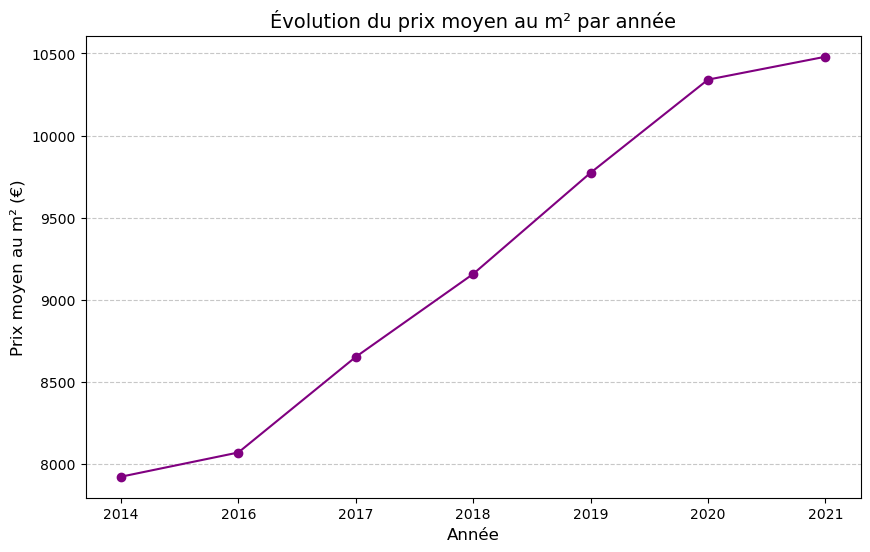

In [47]:
yearly_prices = data_mut_ouest_et_insee.groupby('anneemut')['prix_m2'].mean()
print(yearly_prices)

yearly_prices.plot(kind='line', marker='o', figsize=(10, 6), color='purple')
plt.title('Évolution du prix moyen au m² par année', fontsize=14)
plt.xlabel('Année', fontsize=12)
plt.ylabel('Prix moyen au m² (€)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Le prix au m² connait une hausse régulière sur la période de 2014 à 2021. Cette augmentation reflète une croissance constante du marché immobilier, indiquant une demande soutenue et/ou une offre limitée dans cette zone. En 2014, le prix moyen au m² était d’environ 7 925 €. En 2021, ce prix atteint 10 480 €, soit une augmentation de plus de 32 % en 7 ans. Cette progression représente une croissance moyenne annuelle d’environ 4 %. L'évolution semble s’accélérer à partir de 2018, avec une hausse plus marquée entre 2018 et 2020, où les prix moyens passent de 9 158 € à 10 340 €. Cela pourrait être lié à des facteurs spécifiques, comme une augmentation de la demande, des politiques fiscales, des changements de taux ou des rénovations urbaines dans cette zone. Entre 2020 et 2021, la hausse ralentit légèrement, suggérant une possible stabilisation des prix après une forte croissance.
Il serait donc intéressant de voir si cette évolution est liée à l'encadrement des loyers mis en place à partir du 1er juillet 2019. Cette évolution reflète en tout cas un marché immobilier en croissance constante.

 On s'intéresse ensuite au type de biens vendus (i.e. à la répartition entre maison et appartements).

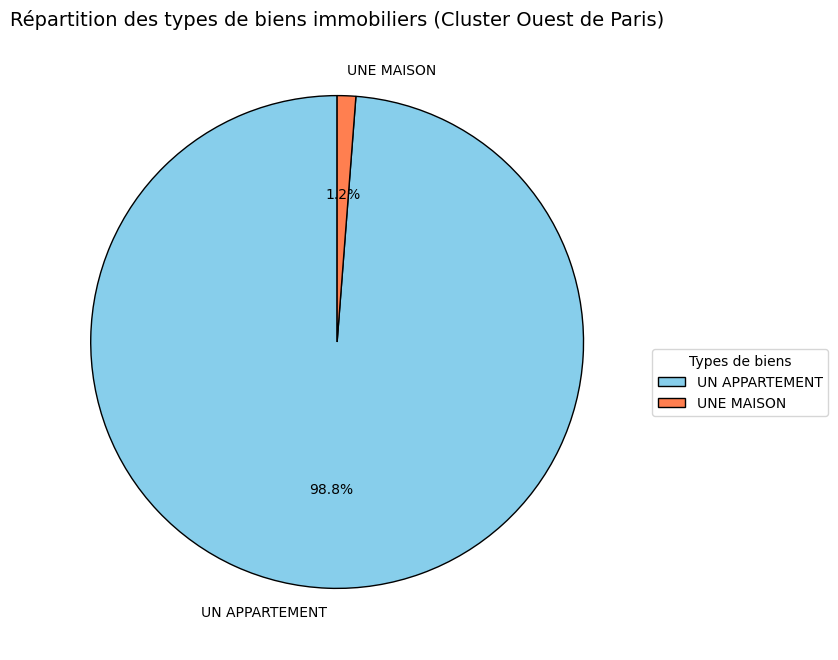

In [48]:
type_counts = data_mut_ouest_et_insee['libtypbien'].value_counts()

plt.figure(figsize=(8, 8))
colors = ['#87CEEB', '#FF7F50']  
type_counts.plot(
    kind='pie', 
    autopct='%1.1f%%', 
    colors=colors, 
    wedgeprops={'edgecolor': 'black'},  
    startangle=90  
)
plt.title("Répartition des types de biens immobiliers (Cluster Ouest de Paris)", fontsize=14)
plt.ylabel('')  
plt.legend(title='Types de biens', loc='upper left', bbox_to_anchor=(1, 0.5))
plt.show()



Ce graphique met en évidence le fait que les appartements dominent largement le marché dans le cluster ouest de Paris, représentant 98,8 % des transactions, tandis que les maisons n'en constituent que 1,2 %. Cette forte disparité reflète le caractère dense et urbain de cette zone, où les biens collectifs sont privilégiés en raison de la disponibilité limitée des terrains pour des maisons individuelles. Ce constat souligne que l’analyse principale du marché devra s’orienter essentiellement sur les dynamiques des appartements, qui constituent presque la totalité du parc immobilier dans ce cluster. C'est également sur ces derniers que l'encadrement des loyers semblent avoir eu le plus de conséquences.

Désormais, on s'intéresse alors à la répartition de la taille à travers la surface en mètre carré des appartements. On réalise alors un histogramme, limité ici à des biens de moins de 300 m². 

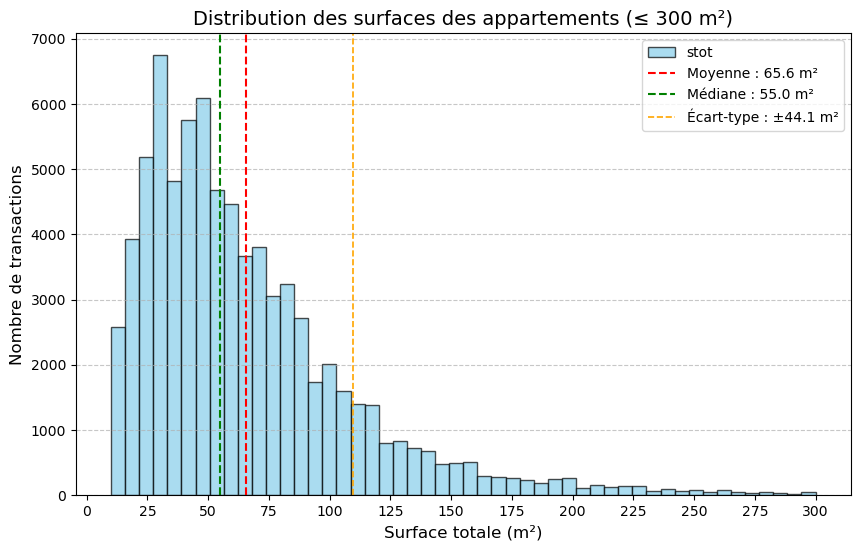

In [49]:
data_appartements = data_mut_ouest_et_insee[data_mut_ouest_et_insee['libtypbien'].str.contains('Appartement', case=False, na=False)]
data_appartements_filtered = data_appartements[data_appartements['stot'] <= 300]


moyenne = data_appartements_filtered['stot'].mean()
mediane = data_appartements_filtered['stot'].median()
ecart_type = data_appartements_filtered['stot'].std()


plt.figure(figsize=(10, 6))
data_appartements_filtered['stot'].plot(
    kind='hist',
    bins=50,  
    color='skyblue',
    edgecolor='black',
    alpha=0.7
)

plt.axvline(moyenne, color='red', linestyle='--', linewidth=1.5, label=f'Moyenne : {moyenne:.1f} m²')
plt.axvline(mediane, color='green', linestyle='--', linewidth=1.5, label=f'Médiane : {mediane:.1f} m²')
plt.axvline(moyenne + ecart_type, color='orange', linestyle='--', linewidth=1.2, label=f'Écart-type : ±{ecart_type:.1f} m²')

plt.title('Distribution des surfaces des appartements (≤ 300 m²)', fontsize=14)
plt.xlabel('Surface totale (m²)', fontsize=12)
plt.ylabel('Nombre de transactions', fontsize=12)
plt.legend()

plt.xticks(range(0, 301, 25))  


plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()



La surface la plus fréquente se situe autour de 50 à 55 m², reflétée également par une médiane de 55 m², ce qui indique que la moitié des transactions concerne des biens de cette taille ou moins. La distribution des surfaces des appartements dans le cluster ouest de Paris montre une prédominance des biens de petite à moyenne taille. Le premier quartile (Q1) est de 34 m², tandis que le troisième quartile (Q3) est de 85 m², indiquant que 75 % des appartements ont une surface inférieure ou égale à cette dernière valeur. En termes de proportions, 45,9 % des transactions concernent des appartements de moins de 50 m², tandis que 37,8 % se situent entre 50 et 100 m², et seulement 16,3 % concernent des appartements de plus de 100 m². Ces chiffres montrent clairement que le marché est dominé par les petites et moyennes surfaces. Les grandes surfaces, bien que présentes, restent minoritaires sur ce marché. 

Pour obtenir plus d'indicateurs numériques sur cette distribution : 

In [50]:
# Quartiles
q1 = data_appartements_filtered['stot'].quantile(0.25)
q3 = data_appartements_filtered['stot'].quantile(0.75)

# Proportions
total_transactions = len(data_appartements_filtered)
below_50 = len(data_appartements_filtered[data_appartements_filtered['stot'] <= 50]) / total_transactions * 100
between_50_100 = len(data_appartements_filtered[(data_appartements_filtered['stot'] > 50) & (data_appartements_filtered['stot'] <= 100)]) / total_transactions * 100
above_100 = len(data_appartements_filtered[data_appartements_filtered['stot'] > 100]) / total_transactions * 100

# Résumé des statistiques
print(f"Premier quartile (Q1) : {q1:.1f} m²")
print(f"Troisième quartile (Q3) : {q3:.1f} m²")
print(f"Proportion < 50 m² : {below_50:.1f}%")
print(f"Proportion 50-100 m² : {between_50_100:.1f}%")
print(f"Proportion > 100 m² : {above_100:.1f}%")



Premier quartile (Q1) : 34.0 m²
Troisième quartile (Q3) : 85.0 m²
Proportion < 50 m² : 45.9%
Proportion 50-100 m² : 37.8%
Proportion > 100 m² : 16.3%



On choisit désormais de se focaliser seulement sur les appartements. Le graphique illustre l'évolution des prix moyens au m² des appartements les six villes du cluster Ouest de Paris entre 2014 et 2021. 

/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


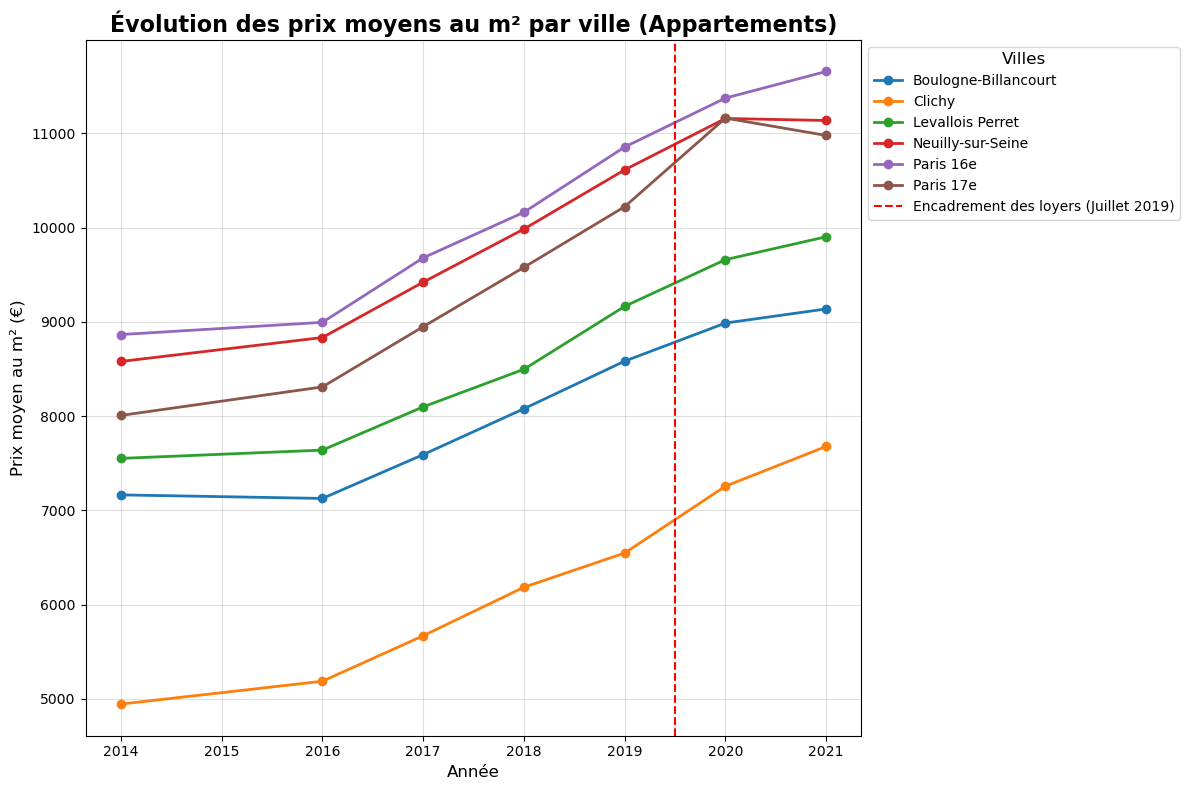

In [51]:
# On filtre par appartements
appartements = data_mut_ouest_et_insee[data_mut_ouest_et_insee['libtypbien'] == 'UN APPARTEMENT']

# On crée un Dictionnaire de correspondance entre codes INSEE et noms des villes
insee_to_ville = {
    "75116": "Paris 16e",
    "75117": "Paris 17e",
    "92012": "Boulogne-Billancourt",
    "92024": "Clichy",
    "92044": "Levallois Perret",
    "92051": "Neuilly-sur-Seine"
}

appartements['nom_ville'] = appartements['l_codinsee'].map(insee_to_ville)

# On calcule les statistiques par ville et par année
stats_par_ville = appartements.groupby(['annee', 'nom_ville'])['prix_m2'].mean().reset_index()

plt.figure(figsize=(12, 8))
for ville in stats_par_ville['nom_ville'].unique():
    subset = stats_par_ville[stats_par_ville['nom_ville'] == ville]
    plt.plot(subset['annee'], subset['prix_m2'], label=ville, marker='o', linewidth=2)

# On ajoute une ligne verticale pour l'encadrement des loyers
plt.axvline(x=2019.5, color='red', linestyle='--', linewidth=1.5, label="Encadrement des loyers (Juillet 2019)")


plt.title("Évolution des prix moyens au m² par ville (Appartements)", fontsize=16, fontweight='bold')
plt.xlabel("Année", fontsize=12)
plt.ylabel("Prix moyen au m² (€)", fontsize=12)


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(title="Villes", fontsize=10, title_fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))  


plt.grid(alpha=0.4)


plt.tight_layout()


plt.show()


On observe une hausse générale et continue des prix dans toutes les villes sur cette période. Parmi elles, Paris 16e et Paris 17e affichent les prix moyens les plus élevés, culminant à environ 11 000 €/m² en 2021, tandis que Clichy reste la ville la plus abordable, avec un prix moyen d'environ 6 000 €/m² la même année. La mise en place de l'encadrement des loyers en juillet 2019, représentée par une ligne rouge verticale, n'a pas semblé ralentir significativement l'augmentation des prix dans la plupart des villes. Toutefois, dans les arrondissements parisiens (16e et 17e), une légère stagnation ou inflexion des prix est perceptible après 2020, suggérant un éventuel effet à retardement de cette politique.

En revanche, les villes périphériques comme Neuilly-sur-Seine, Levallois-Perret et Boulogne-Billancourt continuent d'afficher une croissance soutenue après 2019, témoignant d'un fort dynamisme immobilier dans ces zones. Cette divergence entre les tendances parisiennes et celles des communes limitrophes pourrait refléter une demande accrue pour des appartements qui ne sont pas soumis à l'encadrement des loyers, laissant espérer alors des revenus locatifs plus élevés.

On décide à présent de réaliser une analyse comparative sur l'évolution prix moyens au m² un an avant et un an après l'introduction de l'encadrement des loyers en juillet 2019. Il est plus délicat de comparer sur des périodes plus longues car la base de donnée s'arrête en 2021. Les données révèlent des augmentations significatives dans toutes les villes observées.

In [52]:
date_limite = '2019-07-01'
periode_avant = '2018-07-01'
periode_apres = '2020-06-30'


avant = appartements[(appartements['datemut'] >= periode_avant) & (appartements['datemut'] < date_limite)]
apres = appartements[(appartements['datemut'] >= date_limite) & (appartements['datemut'] <= periode_apres)]


stats_avant = avant.groupby('nom_ville')['prix_m2'].agg(['mean', 'median']).rename(columns={"mean": "moyenne_avant", "median": "mediane_avant"})
stats_apres = apres.groupby('nom_ville')['prix_m2'].agg(['mean', 'median']).rename(columns={"mean": "moyenne_apres", "median": "mediane_apres"})

comparaison = pd.concat([stats_avant, stats_apres], axis=1)

print("Comparaison des prix moyens et médians avant et après juillet 2019 (Appartements uniquement) :")
print(comparaison)




Comparaison des prix moyens et médians avant et après juillet 2019 (Appartements uniquement) :
                      moyenne_avant  mediane_avant  moyenne_apres  \
nom_ville                                                           
Boulogne-Billancourt    8311.337060    8357.309606    8843.814574   
Clichy                  6361.214949    6548.387097    6840.572441   
Levallois Perret        8753.179906    8861.671123    9451.849022   
Neuilly-sur-Seine      10304.586380   10363.636364   10957.744024   
Paris 16e              10439.897295   10526.315789   11204.262803   
Paris 17e               9855.030995   10170.227273   10747.474679   

                      mediane_apres  
nom_ville                            
Boulogne-Billancourt    8888.888889  
Clichy                  7095.238095  
Levallois Perret        9780.000000  
Neuilly-sur-Seine      11084.337349  
Paris 16e              11131.006865  
Paris 17e              10966.304348  


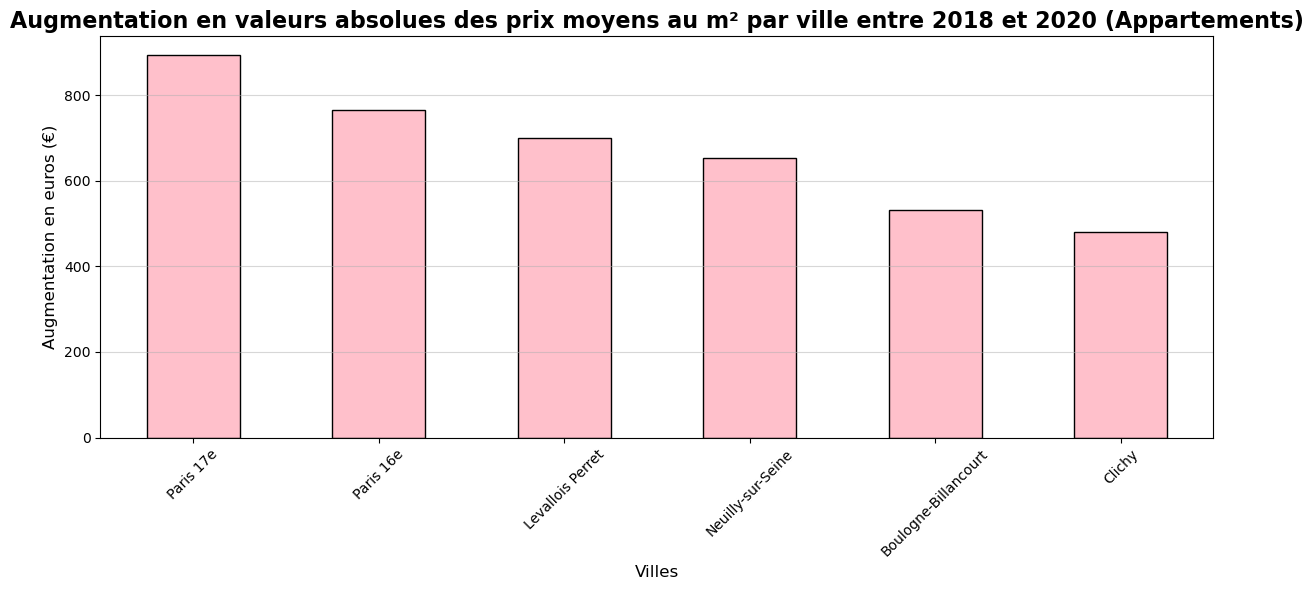

In [54]:
date_limite = '2019-07-01'
periode_avant = '2018-07-01'
periode_apres = '2020-06-30'


avant = appartements[(appartements['datemut'] >= periode_avant) & (appartements['datemut'] < date_limite)]
apres = appartements[(appartements['datemut'] >= date_limite) & (appartements['datemut'] <= periode_apres)]

stats_avant = avant.groupby('nom_ville')['prix_m2'].mean().rename("moyenne_avant")
stats_apres = apres.groupby('nom_ville')['prix_m2'].mean().rename("moyenne_apres")


comparaison = pd.concat([stats_avant, stats_apres], axis=1)


comparaison['augmentation_absolue'] = comparaison['moyenne_apres'] - comparaison['moyenne_avant']

comparaison_triee = comparaison.sort_values(by='augmentation_absolue', ascending=False)


plt.figure(figsize=(12, 6))
comparaison_triee['augmentation_absolue'].plot(kind='bar', color='pink', edgecolor='black')


plt.title("Augmentation en valeurs absolues des prix moyens au m² par ville entre 2018 et 2020 (Appartements)", fontsize=16, fontweight='bold')
plt.xlabel("Villes", fontsize=12)
plt.ylabel("Augmentation en euros (€)", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()





Paris 17e et Paris 16 démontrent les augmentations les plus fortes, autour des 800 € par m² en termes absolus. Cela pourrait être dû à une forte demande dans ces zones, où les effets de l'encadrement des loyers semblent n'avoir eu qu'une influence limitée sur l'augmentation des prix.

Levallois Perret et Neuilly-sur-Seine : Les augmentations absolues dans ces villes se situent également dans une fourchette élevée, entre 700 € et 800 € par m². Ces localités sont caractérisées par une clientèle aisée, ce qui pourrait expliquer la résilience des prix malgré les régulations.

Boulogne-Billancourt et Clichy : Bien que les augmentations soient plus modestes, autour de 500 € à 600 € par m², elles restent significatives. 

Ces observations laissent supposer un effet limité de l'encadrement des loyers.  Bien que l'encadrement des loyers ait été conçu pour stabiliser les prix, les augmentations post-régulation suggèrent que la demande soutenue et l'attractivité des zones étudiées peuvent avoir  contrebalancé cet effet.

On s'intéresse désormais au cluster sud de Paris, correspondant au dataframe data_mut_sud_et_insee pour voir si la tendance est la même dans une zone marquée par davantage de diversité sociale (cette plus forte diversité étant montrée par les statistiques issues de la cellule ci-dessous et par l'analyse qui suit).

In [55]:

variables_socio = [
   'DISP_Q1', 'DISP_MED', 'DISP_Q3', 'DISP_S80S20'
]


paris_data_ouest_socio = data_mut_ouest_et_insee[variables_socio].apply(pd.to_numeric, errors='coerce')
paris_data_sud_socio = data_mut_sud_et_insee[variables_socio].apply(pd.to_numeric, errors='coerce')


mean_ouest = paris_data_ouest_socio.mean(numeric_only=True)
mean_sud = paris_data_sud_socio.mean(numeric_only=True)


comparison = pd.DataFrame({
    'Cluster Ouest': mean_ouest,
    'Cluster Sud': mean_sud
})

print(comparison)


             Cluster Ouest   Cluster Sud
DISP_Q1       22417.284645  20159.225312
DISP_MED      36878.012228  30425.667629
DISP_Q3       57623.986859  43497.028171
DISP_S80S20       9.709230      6.075479


Les statistiques ci-dessous semblent démontrer que le Cluster Ouest se distingue par des disparités de revenus marquées, avec un ratio S80/S20 soit la masse des revenus détenue par les 20 % d'individus les plus riches  par rapport à à celle détenue par les 20 % des personnes les plus pauvres d'en moyenne 9,71 contre 6,07 dans le Cluster Sud, indiquant des inégalités économiques plus prononcées. L'indice de Gini confirme cette tendance, avec une valeur de 0,406 dans l'Ouest contre 0,335 dans le Sud. En termes de revenus, les 1er, 2e et 3e quartiles dans le Cluster Ouest (22 417 €, 36 878 € et 57 624 € respectivement) dépassent largement ceux du Cluster Sud (20 159 €, 30 426 € et 43 497 €). Cette différence reflète une population globalement plus aisée dans l'Ouest. Par ailleurs, la proportion des populations âgées de 15 à 24 ans  et de 25 à 54 ans  montre une présence plus importante de population active dans le Sud, caractéristique d’une plus grande diversité sociale. 
On peut alors supposer une corrélation entre prix de l'immobilier et caractéristiques socio-économiques  puisque le prix moyen au m² est de 9 353 €/m² dans le Cluster Ouest, contre 8 528 €/m² dans le Cluster Sud. Ces chiffres peuvent illustrer l’impact des revenus, des inégalités et de la composition démographique sur les dynamiques du marché immobilier.

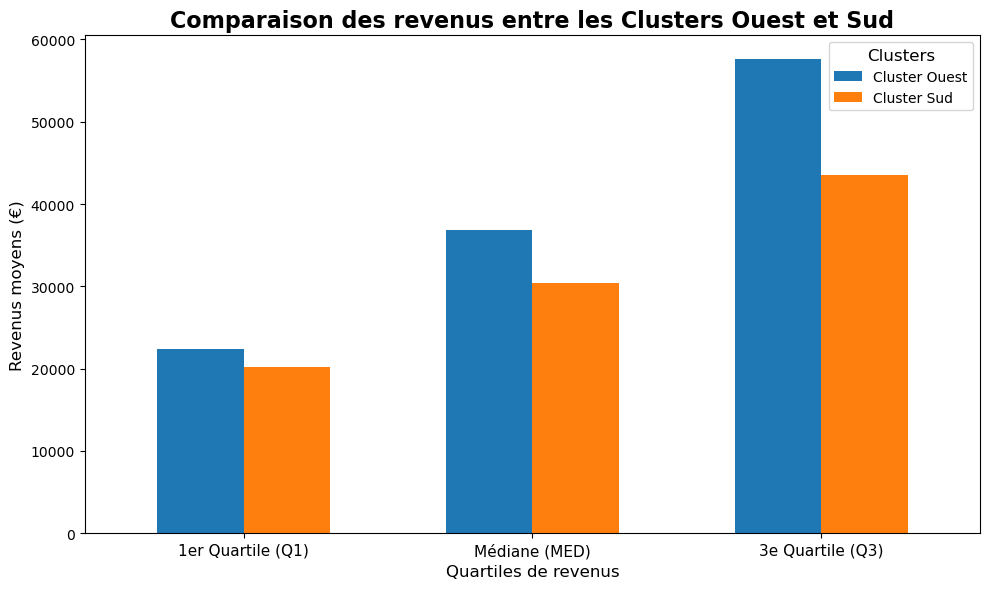

In [56]:
filtered_comparison = comparison.loc[['DISP_Q1', 'DISP_MED', 'DISP_Q3']]

fig, ax = plt.subplots(figsize=(10, 6))

filtered_comparison.plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e'], width=0.6)


ax.set_title("Comparaison des revenus entre les Clusters Ouest et Sud", fontsize=16, fontweight='bold')
ax.set_ylabel("Revenus moyens (€)", fontsize=12)
ax.set_xlabel("Quartiles de revenus", fontsize=12)


ax.set_xticklabels(['1er Quartile (Q1)', 'Médiane (MED)', '3e Quartile (Q3)'], rotation=0, fontsize=11)

ax.legend(title="Clusters", fontsize=10, title_fontsize=12)

plt.tight_layout()
plt.show()


In [57]:

variables_socio = ['DISP_S80S20', 'DISP_GI', 'P_POP1524', 'P_POP2554','DISP_Q1', 'DISP_MED', 'DISP_Q3','prix_m2']

paris_data_ouest_socio = data_mut_ouest_et_insee[variables_socio].dropna()
paris_data_sud_socio = data_mut_sud_et_insee[variables_socio].dropna()


paris_data_ouest_socio = paris_data_ouest_socio.apply(pd.to_numeric, errors='coerce')
paris_data_sud_socio = paris_data_sud_socio.apply(pd.to_numeric, errors='coerce')


On calcule ensuite des corrélations entre le prix au m² et certaines variables issues des bases Insee, pour avoir une première idée des variables qui pourraient influencer l'évolution des prix de l'immobilier et donc savoir quelles seront nos variables de contrôle dans la partie de modélisation avec le difference-in-difference. 

In [58]:
# Calcul des corrélations entre les variables socio-économiques et le prix au m² pour chaque cluster
correlation_ouest = paris_data_ouest_socio.corr()['prix_m2']
correlation_sud = paris_data_sud_socio.corr()['prix_m2']

# Afficher les corrélations
print("Corrélations dans le Cluster Ouest :\n", correlation_ouest)
print("\nCorrélations dans le Cluster Sud :\n", correlation_sud)


Corrélations dans le Cluster Ouest :
 DISP_S80S20    0.296903
DISP_GI        0.332553
P_POP1524     -0.014585
P_POP2554     -0.103117
DISP_Q1        0.212038
DISP_MED       0.251149
DISP_Q3        0.262360
prix_m2        1.000000
Name: prix_m2, dtype: float64

Corrélations dans le Cluster Sud :
 DISP_S80S20    0.138930
DISP_GI        0.148775
P_POP1524     -0.067703
P_POP2554     -0.090608
DISP_Q1        0.189948
DISP_MED       0.223611
DISP_Q3        0.238502
prix_m2        1.000000
Name: prix_m2, dtype: float64


On observe que la plus forte corrélation observée entre quelques variables choisies pour leur sens économique et le prix au m² est celle avec le revenu disponible médian (ou au 3ème quartile à quelques décimales près). Une explication possible est l'idée que les personnes les plus aisées choisiraient d'acheter dans les quartiers les plus agréables à vivre (transports, commerce, écoles, etc) et donc les plus chers car les plus demandés. 

On va désormais faire le même tye d'analyse mais sur la partie Sud. 


Le graphique et les calculs ci dessous s'intéressent aux variations des prix des appartements, et plus précisément le prix moyens au mètre carré dans le cluster Sud de Paris avant et après l'instauration de l’encadrement des loyers en juillet 2019. Cette analyse révèle des dynamiques variées selon les villes, mais suggère une tendance générale à la hausse des prix, même dans les zones soumises à l’encadrement.

/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


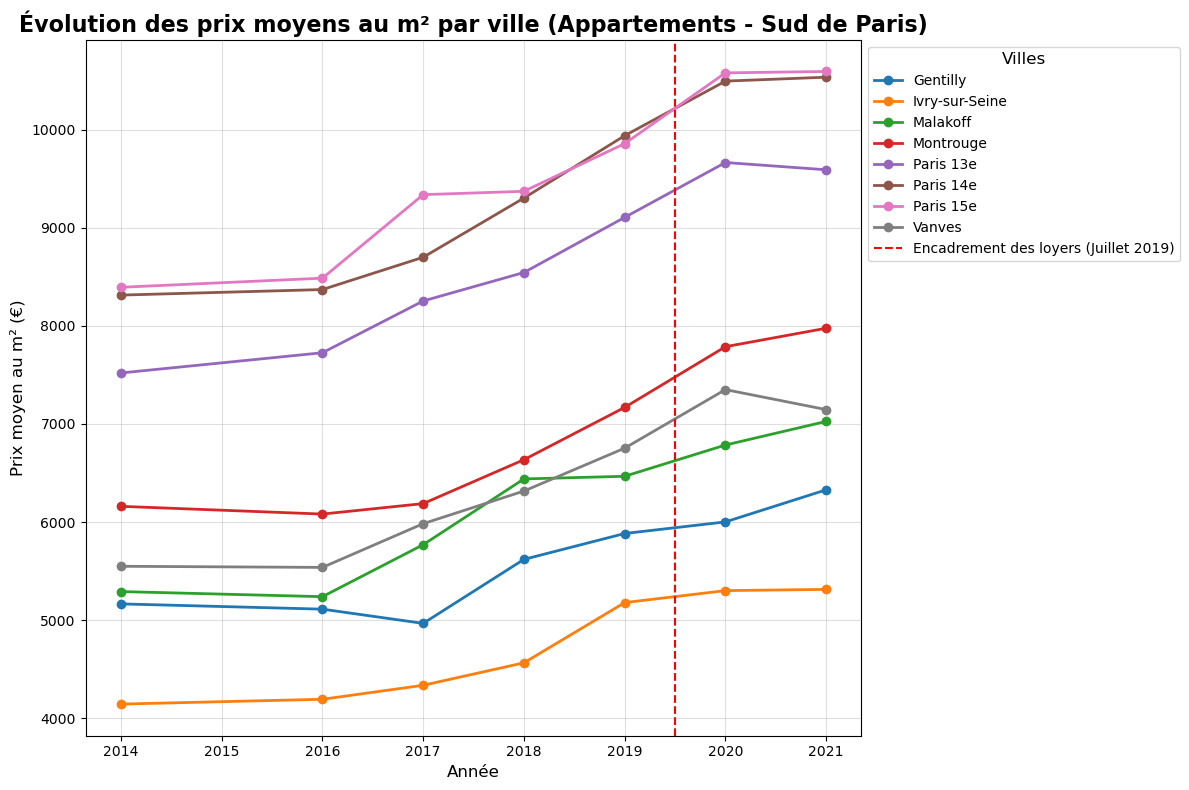

In [59]:

appartements_sud = data_mut_sud_et_insee[data_mut_sud_et_insee['libtypbien'] == 'UN APPARTEMENT']



insee_to_ville_sud = {
    "75113": "Paris 13e",
    "75114": "Paris 14e",
    "75115": "Paris 15e",
    "92046": "Malakoff",
    "92049": "Montrouge",
    "92075": "Vanves",
    "94037": "Gentilly",
    "94041": "Ivry-sur-Seine"
}


appartements_sud['nom_ville'] = appartements_sud['l_codinsee'].map(insee_to_ville_sud)


stats_par_ville_sud = appartements_sud.groupby(['annee', 'nom_ville'])['prix_m2'].mean().reset_index()
stats_par_ville_sud['annee'] = stats_par_ville_sud['annee'].astype(int)

plt.figure(figsize=(12, 8))
for ville in stats_par_ville_sud['nom_ville'].unique():
    subset = stats_par_ville_sud[stats_par_ville_sud['nom_ville'] == ville]
    plt.plot(subset['annee'], subset['prix_m2'], label=ville, marker='o', linewidth=2)

plt.axvline(x=2019.5, color='red', linestyle='--', linewidth=1.5, label="Encadrement des loyers (Juillet 2019)")


plt.title("Évolution des prix moyens au m² par ville (Appartements - Sud de Paris)", fontsize=16, fontweight='bold')
plt.xlabel("Année", fontsize=12)
plt.ylabel("Prix moyen au m² (€)", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(title="Villes", fontsize=10, title_fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))  
plt.grid(alpha=0.4)


plt.tight_layout()

plt.show()


In [60]:

# Calcul de la variation annuelle des prix moyens par ville
stats_variation_sud = stats_par_ville_sud.copy()
stats_variation_sud['variation_annuelle'] = stats_variation_sud.groupby('nom_ville')['prix_m2'].pct_change() * 100

# Filtrage des données avant et après 2020
avant_2019_sud = stats_variation_sud[stats_variation_sud['annee'] < 2020]
apres_2019_sud = stats_variation_sud[stats_variation_sud['annee'] >= 2020]

moyenne_avant_2019_sud = avant_2019_sud.groupby('nom_ville')['prix_m2'].mean()
moyenne_apres_2019_sud = apres_2019_sud.groupby('nom_ville')['prix_m2'].mean()


variation_moyenne_annuelle_sud = stats_variation_sud.groupby('nom_ville')['variation_annuelle'].mean()

variations_par_ville_sud = pd.DataFrame({
    'moyenne_avant_2019': moyenne_avant_2019_sud,
    'moyenne_apres_2019': moyenne_apres_2019_sud,
    'variation_moyenne_annuelle': variation_moyenne_annuelle_sud
}).reset_index()


print("Variations moyennes avant et après l'encadrement des loyers :")
print(variations_par_ville_sud)



Variations moyennes avant et après l'encadrement des loyers :
        nom_ville  moyenne_avant_2019  moyenne_apres_2019  \
0        Gentilly         5349.641225         6165.104686   
1  Ivry-sur-Seine         4483.809558         5307.444658   
2        Malakoff         5841.238803         6905.479396   
3       Montrouge         6446.859568         7881.471192   
4       Paris 13e         8229.671182         9627.838387   
5       Paris 14e         8924.694353        10514.577285   
6       Paris 15e         9089.067356        10585.734333   
7          Vanves         6027.979643         7248.230924   

   variation_moyenne_annuelle  
0                    3.568091  
1                    4.317577  
2                    4.939937  
3                    4.464239  
4                    4.173179  
5                    4.060276  
6                    4.023568  
7                    4.398260  



Avant 2019, les prix des appartements dans les villes de ce cluster étaient plus homogènes qu'après 2019, oscillant autour de 5000 à 6000 euros le m² dans les zones moins centrales, et légèrement plus élevés dans les quartiers plus recherchés comme Paris 13e, 14e et 15e. Toutefois, après l'introduction de l'encadrement des loyers, qui visait à contenir l'envolée des loyers dans les zones où la pression immobilière est la plus forte, les prix semblent avoir continué d'augmenter de manière notable, bien que la tendance varie d'une ville à l'autre.

Les villes telles que Paris 14e et Paris 15e, qui sont soumises à l'encadrement des loyers, ont vu une forte hausse des prix des appartements. Ces hausses ont été particulièrement marquées entre 2019 et 2020, avec des augmentations annuelles respectivement de 6.06% et 5.62%. Ce phénomène pourrait être dû à la demande toujours croissante dans ces quartiers relativement attractifs. Bien qu'on aurait pu supposer que l'encadrement fasse baisser le prix de l'immobilier en raison d'une moindre demande potentielle causée par une perspective plus faible de revenus locatifs', il semble que dans ces quartiers, la demande a maintenu la pression sur les prix.

En revanche, d'autres villes comme Gentilly, Ivry-sur-Seine et Vanves, situées en périphérie, ont connu elles des hausses moins prononcées, avec des augmentations annuelles allant de 3.56% à 4.46%. Ces villes, bien que proches du centre, sont peut-être moins exposées à la spéculation immobilière, ce qui explique une croissance plus modérée des prix. Ainsi, la demande ne semble pas s'être reportée sur ces villes. En revanche, des villes comme Malakoff et Montrouge, qui connaissent un développement urbain et des projets d'infrastructure importants, ont aussi vu des hausses de prix significatives, bien que ces dernières restent en deçà de celles observées dans les zones centrales.

Ainsi, même avec l’introduction de l'encadrement des loyers en 2019, qui visait à réguler les prix dans les zones à forte demande, les prix des appartements continuent d'augmenter davantage dans les zones soumises à encadrement. Cela suggère que d'autres facteurs, tels que l'attractivité croissante de certaines zones ou les améliorations d'infrastructure, jouent également un rôle tout aussi déterminant que les politiques de régulation des loyers dans l'évolution des prix immobiliers.

Intéressons-nous ensuite à l'évolution de la proportion de résidence principale. 

/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


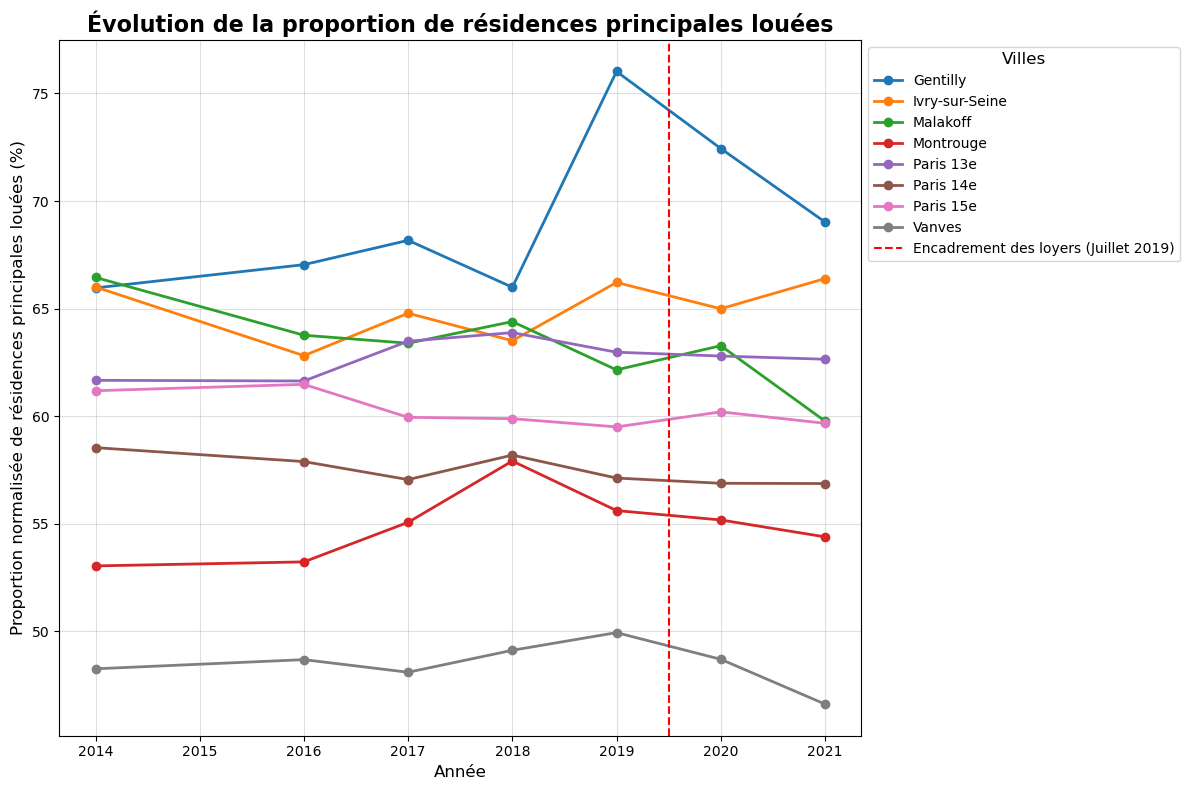

In [61]:
if 'P_RP' in appartements_sud.columns:
    appartements_sud['P_RP_LOC_normalized'] = (appartements_sud['P_RP_LOC'] / appartements_sud['P_RP']) * 100
else:
    print("colonne pas dispo")

stats_par_ville_sud = appartements_sud.groupby(['annee', 'nom_ville'])['P_RP_LOC_normalized'].mean().reset_index()
stats_par_ville_sud['annee'] = stats_par_ville_sud['annee'].astype(int)

plt.figure(figsize=(12, 8))
couleurs = sns.color_palette("tab10", len(stats_par_ville_sud['nom_ville'].unique()))

for i, ville in enumerate(stats_par_ville_sud['nom_ville'].unique()):
    subset = stats_par_ville_sud[stats_par_ville_sud['nom_ville'] == ville]
    plt.plot(
        subset['annee'], 
        subset['P_RP_LOC_normalized'], 
        label=ville, 
        marker='o', 
        linewidth=2, 
        color=couleurs[i]
    )

plt.axvline(x=2019.5, color='red', linestyle='--', linewidth=1.5, label="Encadrement des loyers (Juillet 2019)")
plt.title("Évolution de la proportion de résidences principales louées", fontsize=16, fontweight='bold')
plt.xlabel("Année", fontsize=12)
plt.ylabel("Proportion normalisée de résidences principales louées (%)", fontsize=12)
plt.legend(title="Villes", fontsize=10, title_fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


Sur le graphique ci-dessous, on observe l’évolution  de la proportion de résidences principales louées (P_RP_LOC) entre 2014 et 2021. Le graphique met en évidence des dynamiques contrastées entre les arrondissements parisiens soumis à l’encadrement des loyers (Paris 13e, 14e, et 15e) et les villes voisines non soumises (Malakoff, Montrouge, Gentilly, Vanves, Ivry-sur-Seine). Avant 2019, les proportions de logements loués étaient relativement stables dans les arrondissements parisiens, oscillant entre 58 % et 63 %. En revanche, certaines villes voisines, comme Gentilly (65 % à 76 %) et Ivry-sur-Seine (62 % à 66 %), présentaient des variations plus marquées.

Après l’introduction de l’encadrement des loyers en juillet 2019, une légère baisse est perceptible dans les arrondissements parisiens : Paris 13e passe de 63 % en 2019 à 61 % en 2021, et Paris 14e passe de 57 % à 55 % sur la même période. Les villes voisines montrent des évolutions plus hétérogènes. Par exemple, Gentilly chute brusquement de 76 % en 2019 à 65 % en 2020, tandis qu’Ivry-sur-Seine augmente de 64 % en 2018 à 66 % en 2021. Ces fluctuations suggèrent des dynamiques plus complexes, potentiellement influencées par l’attractivité relative des zones non encadrées pour les locataires et investisseurs cherchant à éviter les restrictions à Paris.

Ces résultats indiquent que l’encadrement des loyers a pu potentiellement stabiliser, voire quelque peu abaissé la proportion de résidences louées dans les zones réglementées, tout en générant des effets secondaires dans certaines villes voisines non soumises, où les variations sont  un peu plus importantes. 

# IV. Modélisation : Differences in differences

**1. DID naïf**

On cherche à appliquer le modèle du difference in differences (DID) à deux ensembles : l'Ouest parisien et le Sud parisien. Commençons par l'ouest. On se réfère au modèle mathématique du DID présenté sur la page [Wikipédia](https://en.wikipedia.org/wiki/Difference_in_differences) en anglais. 

On commence par élminier certaines valeurs aberrantes qui peuvent fausser notre travail.

In [62]:
print((data_mut_ouest_et_insee['prix_m2'] < 2000).sum())
print((data_mut_ouest_et_insee['prix_m2'] > 30000).sum())

2083
85


In [63]:
data_mut_ouest_et_insee = data_mut_ouest_et_insee[data_mut_ouest_et_insee['prix_m2'] >= 2000]
data_mut_ouest_et_insee = data_mut_ouest_et_insee[data_mut_ouest_et_insee['prix_m2'] <= 30000]

In [64]:
data_mut_sud_et_insee = data_mut_sud_et_insee[data_mut_sud_et_insee['prix_m2'] >= 2000]
data_mut_sud_et_insee = data_mut_sud_et_insee[data_mut_sud_et_insee['prix_m2'] <= 30000]

In [65]:
print(data_mut_ouest_et_insee.shape)
print(data_mut_sud_et_insee.shape)

(75585, 239)
(70075, 239)


In [66]:
data_mut_ouest_et_insee['anneemut'] = data_mut_ouest_et_insee['anneemut'].astype(str)
data_mut_sud_et_insee['anneemut'] = data_mut_sud_et_insee['anneemut'].astype(str)

Avant toute chose, ajoutons à chacun de nos jeux de données une colonne pour savoir si la vente a eu lieu avant ou après l'encadrement des loyers.

In [67]:
cutoff_date = np.datetime64('2019-07-01T12:00:00.123') #on fixe le seuil au 1er juillet 2019, date d'entrée en vigueur 
#de l'encadrement
data_mut_ouest_et_insee['periode'] = data_mut_ouest_et_insee['datemut'].apply(
    lambda x: 0 if x < cutoff_date else 1
)
data_mut_sud_et_insee['periode'] = data_mut_sud_et_insee['datemut'].apply(
    lambda x: 0 if x < cutoff_date else 1
)

Commençons par la zone (ou le cluster) Ouest. On sépare notre cluster en un groupe contrôle (villes en bordures du périphérique) et un groupe traitement (arrondissements parisiens en bordure du périphérique). 

In [68]:
crtl_ouest = data_mut_ouest_et_insee[data_mut_ouest_et_insee['coddep']=='92']
trtm_ouest = data_mut_ouest_et_insee[data_mut_ouest_et_insee['coddep']=='75']

On va réaliser un DID sur le prix moyen au mètre carré, en acceptant l'hypothèse que la tendance d'évolution dans le temps des deux groupes est similaire. 

On calcule les valeurs de notre variable d'intérêt pour le groupe contrôle avant et après traitement.

In [69]:
s1 = crtl_ouest[crtl_ouest['periode']==0]['prix_m2'].mean()
s2 = crtl_ouest[crtl_ouest['periode']==1]['prix_m2'].mean()

On refait la même chose pour le groupe traitement avant et après traitement.

In [70]:
p1 = trtm_ouest[trtm_ouest['periode']==0]['prix_m2'].mean()
p2 = trtm_ouest[trtm_ouest['periode']==1]['prix_m2'].mean()

#On conserve ces valeurs dans une liste, on en aura besoin pour les retrouver plus tard 
#alors qu'on aura réassigné à s1, s2, etc. les valeurs pour le cluster sud. 
list_val_ouest = [float(s1), float(s2), float(p1), float(p2)]

On peut désormais réaliser un graphique montrant cette différence de différences :

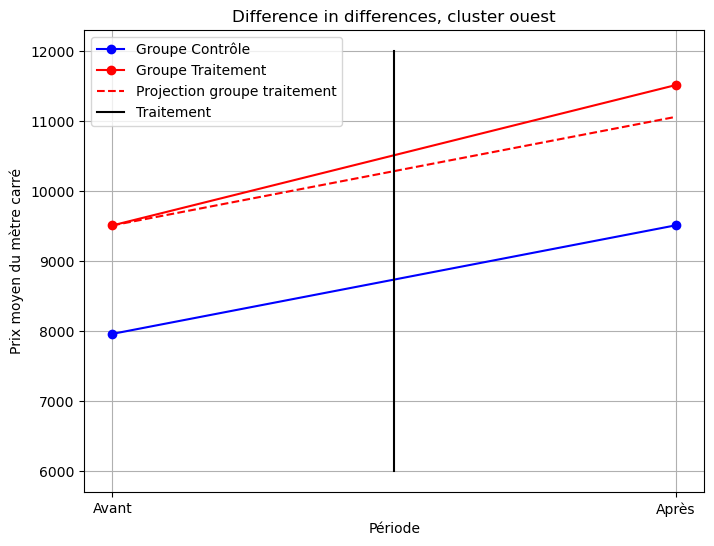

In [71]:
periode = ['Avant', 'Après']

# Création du graphique
plt.figure(figsize=(8, 6))


#On trace les trois droites (évolutions réelles et projetée)
plt.plot(periode, [s1, s2], marker='o', label='Groupe Contrôle', color='blue')
plt.plot(periode, [p1, p2], marker='o', label='Groupe Traitement', color='red')
plt.plot(periode, [p1, p1 + (s2 - s1)], linestyle='--', label='Projection groupe traitement', color='red')

#on ajoute une droite représentant le tratitement
plt.plot([0.5, 0.5], [6000,12000], label='Traitement', color='black')


plt.xlabel('Période')
plt.ylabel('Prix moyen du mètre carré')
plt.title('Difference in differences, cluster ouest')
plt.legend()

plt.grid(True)
plt.show()

Et la valeur numérique : 

In [72]:
print((p2-p1)-(s2-s1))

454.11331351336594


Ce résultat est contre-intuitif : si l'hypothèse de tendance identique tient, l'encadrement des loyers est donc corrélé à une augmentation du prix moyen au mètre carré. Voyons d'abord ce qu'il en est dans le cluster sud, que les statistiques ont décrite comme plus diverse socialement.

In [73]:
crtl_sud = data_mut_sud_et_insee[data_mut_sud_et_insee['coddep'].isin(['92', '94'])]
trtm_sud = data_mut_sud_et_insee[data_mut_sud_et_insee['coddep']=='75']

In [74]:
s1 = crtl_sud[crtl_sud['periode']==0]['prix_m2'].mean()
s2 = crtl_sud[crtl_sud['periode']==1]['prix_m2'].mean()

In [75]:
p1 = trtm_sud[trtm_sud['periode']==0]['prix_m2'].mean()
p2 = trtm_sud[trtm_sud['periode']==1]['prix_m2'].mean()
list_val_sud = [float(s1), float(s2), float(p1), float(p2)]

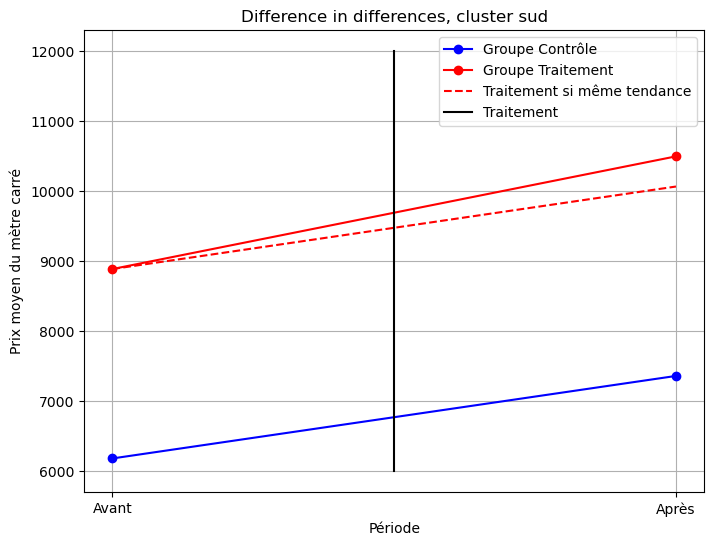

In [76]:
periode = ['Avant', 'Après']

# Création du graphique
plt.figure(figsize=(8, 6))

#On trace les droites
plt.plot(periode, [s1, s2], marker='o', label='Groupe Contrôle', color='blue')
plt.plot(periode, [p1, p2], marker='o', label='Groupe Traitement', color='red')
plt.plot(periode, [p1, p1 + (s2 - s1)], linestyle='--', label='Traitement si même tendance', color='red')
plt.plot([0.5, 0.5], [6000,12000], label='Traitement', color='black')

#On ajoute la légende
plt.xlabel('Période')
plt.ylabel('Prix moyen du mètre carré')
plt.title('Difference in differences, cluster sud')
plt.legend()

# Afficher le graphique
plt.grid(True)
plt.show()

In [77]:
print((p2-p1)-(s2-s1))

430.8302780422109


On obtient ici aussi le même phénomène, et en plus avec une valeur remarquablement proche. D'après ce modèle donc, l'encadrement des loyers impacte presque de la même manière le prix au mètre carré des arrondissements au sud et à l'ouest de Paris : il les fait augmenter d'environ 440 euros. 

Quels sont les limites de ce modèle ? 

D'abord, peut-être un biais lié à l'étalement temporel de nos observation en amont du traitement : peut-être que $P_1$ (le prix moyen dans le groupe traité avant la mise en place de l'encadrement des loyers) est tiré vers le bas par les ventes datant de 2014. Mais cela ne devrait pas poser problème : en effet, de la même manière, $S_1$ (le prix moyen dans le groupe contrôle avant la mise en place de l'enacdrement des loyers) est tiré vers le bas par les ventes de 2014. Et comme on l'a vu dans la partie statistiques descriptives, la croissance du prix au mètre carré est relativement similaire entre arrondissements et villes de banlieues. 

Par contre, il y a peut-être un problème avec le choix de notre variable d'intérêt. En effet, on regarde le prix moyen au mètre carré. Nous avons vu que l'encadrement des loyers ne le fait pas baisser. Mais s'attendre à une baisse du prix, c'est demander un effet massif. Peut-être y a-t-il un effet plus léger à observer à travers la vitesse d'accroissement du prix, d'autant que les statistiques descriptives nous ont déjà indiqué cette piste.

Il se pourrait en effet que le prix continue d'augmenter dans les arrondissements parisiens, mais moins vite que dans les banlieues.

Pour étudier cela, on va regarder la vitesse de croissance du prix dans chaque groupe entre trois dates : entre 2014 et 2018-2019 avant traitement, puis entre 2018 - 2019 et 2019 - 2020 après traitement. Si l'encadrement des prix ralentit la vitesse de croissance des prix, sous hypothèse de même tendance, la croissance des prix observée en deuxième période sur le groupe traitement sera inférieure à la croissance projetée à partir de la croissance en première période du groupe traitement et de la croissance en deuxième période du groupe contrôle. 

In [78]:
base_100_crtl = crtl_sud[crtl_sud['anneemut']=='2014']['prix_m2'].mean()
base_100_trtm = trtm_sud[trtm_sud['anneemut']=='2014']['prix_m2'].mean()
print(base_100_crtl, base_100_trtm)

5747.692053543837 8343.362574315868


Regardons l'augmentation des prix entre les ventes en 2018 - 2019 avant le traitement  et les ventes en 2014 : 

In [79]:
df_pre_crtl_sud = crtl_sud[crtl_sud['anneemut'].isin(['2018', '2019']) & crtl_sud['periode']==0]
df_pre_trtm_sud = trtm_sud[trtm_sud['anneemut'].isin(['2018', '2019']) & trtm_sud['periode']==0]

In [80]:
hausse_pre_crtl_sud = df_pre_crtl_sud['prix_m2'].mean() * 100 / base_100_crtl
hausse_pre_trtml_sud = df_pre_trtm_sud['prix_m2'].mean() * 100 / base_100_trtm
print(hausse_pre_crtl_sud, hausse_pre_trtml_sud)

116.3384647030798 114.36959673468688


Regardons maintenant l'augmentation des prix entre 2018 - 2019 avant traitement et 2019 - 2020 après traitement :

In [81]:
df_post_crtl_sud = crtl_sud[crtl_sud['anneemut'].isin(['2020', '2019']) & crtl_sud['periode']==1]
df_post_trtm_sud = trtm_sud[trtm_sud['anneemut'].isin(['2020', '2019']) & trtm_sud['periode']==1]

In [82]:
hausse_post_crtl_sud = df_post_crtl_sud['prix_m2'].mean() * 100 / df_pre_crtl_sud['prix_m2'].mean()
hausse_post_trtml_sud = df_post_trtm_sud['prix_m2'].mean() * 100 / df_pre_trtm_sud['prix_m2'].mean()

Réalisons maintenant le graphique : 

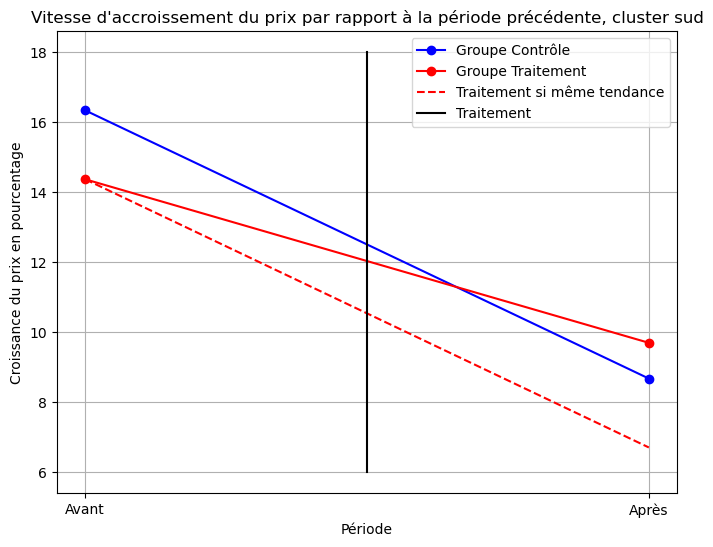

In [ ]:
periode = ['2014 à 2018-2019', '2018-2019 à 2019-2020']

# Création du graphique
plt.figure(figsize=(8, 6))

plt.plot(periode, [hausse_pre_crtl_sud - 100, hausse_post_crtl_sud - 100], marker='o', label='Groupe Contrôle', color='blue')
plt.plot(periode, [hausse_pre_trtml_sud - 100, hausse_post_trtml_sud - 100], marker='o', label='Groupe Traitement', color='red')
plt.plot(periode, [hausse_pre_trtml_sud - 100, hausse_pre_trtml_sud -100 + (hausse_post_crtl_sud - hausse_pre_crtl_sud)], linestyle='--', label='Traitement si même tendance', color='red')
plt.plot([0.5, 0.5], [6,18], label='Traitement', color='black')


plt.xlabel('Période')
plt.ylabel('Croissance du prix en pourcentage')
plt.title('Vitesse d\'accroissement du prix par rapport à la période précédente, cluster sud')
plt.legend()

# Afficher le graphique
plt.grid(True)
plt.show()

Nous aboutissons à un résultat encore plus surprenant : non seulement l'encadrement des loyers est n'est pas corrélé à une baisse des prix de vente, mais il est aussi corrélé à une accélération de la hausse de ces prix de vente. En effet, le taux de croissance des prix est plus élevé dans les arrondissements parisiens après l'encadrement que dans les villes de banlieue. 

Vérifions rapidement si on obtient la même chose pour le cluster ouest : 

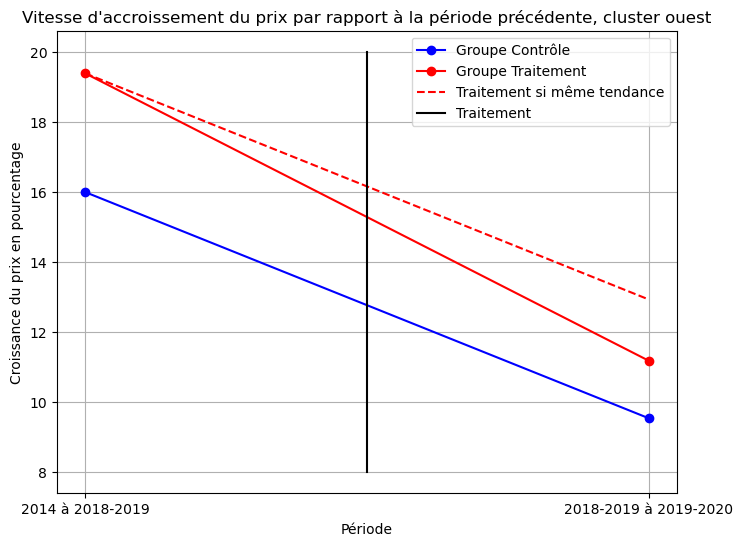

In [104]:
#Définition de la base 100
base_100_crtl = crtl_ouest[crtl_ouest['anneemut']=='2014']['prix_m2'].mean()
base_100_trtm = trtm_ouest[trtm_ouest['anneemut']=='2014']['prix_m2'].mean()

#Calcul de la hausse en 2018 - 2019
df_pre_crtl_ouest = crtl_ouest[crtl_ouest['anneemut'].isin(['2018', '2019']) & crtl_ouest['periode']==0]
df_pre_trtm_ouest = trtm_ouest[trtm_ouest['anneemut'].isin(['2018', '2019']) & trtm_ouest['periode']==0]

hausse_pre_crtl_ouest = df_pre_crtl_ouest['prix_m2'].mean() * 100 / base_100_crtl
hausse_pre_trtm_ouest = df_pre_trtm_ouest['prix_m2'].mean() * 100 / base_100_trtm

#Calcul de la hausse en 2019 - 2020
df_post_crtl_ouest = crtl_ouest[crtl_ouest['anneemut'].isin(['2020', '2019']) & crtl_ouest['periode']==1]
df_post_trtm_ouest = trtm_ouest[trtm_ouest['anneemut'].isin(['2020', '2019']) & trtm_ouest['periode']==1]

hausse_post_crtl_ouest = df_post_crtl_ouest['prix_m2'].mean() * 100 / df_pre_crtl_ouest['prix_m2'].mean()
hausse_post_trtm_ouest = df_post_trtm_ouest['prix_m2'].mean() * 100 / df_pre_trtm_ouest['prix_m2'].mean()


periode = ['2014 à 2018-2019', '2018-2019 à 2019-2020']

# Création du graphique
plt.figure(figsize=(8, 6))

plt.plot(periode, [hausse_pre_crtl_ouest - 100, hausse_post_crtl_ouest- 100], marker='o', label='Groupe Contrôle', color='blue')
plt.plot(periode, [hausse_pre_trtm_ouest- 100, hausse_post_trtm_ouest- 100], marker='o', label='Groupe Traitement', color='red')
plt.plot(periode, [hausse_pre_trtm_ouest- 100, hausse_pre_trtm_ouest - 100 + (hausse_post_crtl_ouest - hausse_pre_crtl_ouest)], linestyle='--', label='Traitement si même tendance', color='red')
plt.plot([0.5, 0.5], [8,20], label='Traitement', color='black')


plt.xlabel('Période')
plt.ylabel('Croissance du prix en pourcentage')
plt.title('Vitesse d\'accroissement du prix par rapport à la période précédente, cluster ouest')
plt.legend()

# Afficher le graphique
plt.grid(True)
plt.show()

Ici, on a une baisse plus rapide dans le groupe traitement que dans le groupe contrôle : sous l'hypothèse de croissance similaire, l'encadrement des prix a bien un effet, celui de ralentir la croissance des prix (les prix croissent toujours). 

La différence de comportement entre les deux clusters peut tenir à la différence de niveau de vie mis en évidence dans la partie statistiques descriptives : dans le Cluster Ouest, le revenu médian et le 3e quartile du revenu sont plus élevés que ces mêmes indicateurs pour le Cluster Sud. 

Soulignons quand même les limites de ce modèle : le fait de nous focaliser sur la croissance des prix entre périodes affaiblit encore l'hypothèse de même tendance du DID, car non seulement la tendance doit être la même entre deux groupes différents, mais elle doit être la même sur des périodes de comparaison arbitraires. Peut-être qu'avec un autre découpage temporel, la croissance du groupe contrôle en première période aurait été plus forte et la chute donc plus importante, faisant alors coïncider l'évolution réelle du groupe traitement avec son évolution projetée. 

Cependant, on se limite au découpage proposé car comme l'a montré la partie descriptives, les prix augmentent sans cesse. Donc le découpage, bien qu'arbitraire, n'est pas susceptible de tomber sur des périodes de retournement des tendances.

**2. Meilleure modélisation de la tendance**

L'une des raisons de nos résultats surprenants peut résider dans la limite principale du DID, qui est l'hypothèse de tendance similaire. Autrement dit, on observe directement $S_1, S_2, P_1, P_2, $  donc il n'y a rien à changer de ce côté. Par contre, on observe pas $Q$, le prix moyen du mètre carré du groupe traitement s'il n'y avait pas eu de traitement. C'est ici qu'il y a une piste d'amélioration. 

Toute l'idée du modèle DID est de prédire l'évolution projetée du groupe traitement à partir de l'évolution observée du groupe contrôle. Mais on peut essayer une autre méthode, d'autant qu'on dispose de nombreuses variables INSEE qu'on n'a pas du tout exploitées. Pour reprendre le modèle de Wikipedia, on a $ Q = \gamma_{s(2)} + \lambda_{2} + \epsilon_{2}$. Dans le cadre du DID, on a fait comme si le $\lambda_t$ était purement indépendant des caractéristiques de chaque groupe. Mais on peut envisager les choses différement : on veut prédire $Q$ à partir des variables INSEE dont on dispose,  donc on veut $\lambda_t = X^T\beta$, où $X$ comprendra certaines variables INSEE. 

Comment déterminer ce $\beta$ ? L'objectif est d'obtenir la meilleure prédiction du prix moyen au mètre carré, sachant le jeu $(X_i, Y_i)_{i = 1, ..., n}$ et l'observation $X_{n+1}$. On peut donc recourir à un estimateur LASSO. 

On ne peut pas simplement sélectionner toutes les variables INSEE, sinon on aurait une parfaite collinéarité entre certaines de nos covariables (par exemple, entre le nombre de femmes, le nombre d'hommes et le nombre d'habitants).

De plus, presque toutes les variables INSEE sont des quantités, et non des taux en proportion de la population de l'IRIS. En conséquence, la densité dans un IRIS peut brouiller l'effet d'une variable sur le prix moyen au mètre carré. On va donc commencer par forger les covariables que l'on souhaite utiliser : des taux non parfaitement collinéaires entre eux.

In [86]:
data_mut_ouest_et_insee['prix_m2'] = data_mut_ouest_et_insee['valeurfonc'] / data_mut_ouest_et_insee['stot']
data_mut_ouest_et_insee['prop_h'] = data_mut_ouest_et_insee['P_H1564'] / data_mut_ouest_et_insee['P_POP1564']
data_mut_ouest_et_insee['tx_chom'] = data_mut_ouest_et_insee['P_CHOM1564'] / data_mut_ouest_et_insee['P_ACT1564']
data_mut_ouest_et_insee['prop_ht_diplome'] = data_mut_ouest_et_insee['C_ACT1564_CS3'] / data_mut_ouest_et_insee['P_ACT1564']
data_mut_ouest_et_insee['prop_maison'] = data_mut_ouest_et_insee['P_MAISON'] / data_mut_ouest_et_insee['P_LOG']
data_mut_ouest_et_insee['prop_res_princ'] = data_mut_ouest_et_insee['P_RP'] / data_mut_ouest_et_insee['P_LOG']

list_covar = ['prop_h', 'tx_chom',"prop_ht_diplome", "prop_maison", "prop_res_princ"]


On va également s'assurer de pouvoir utiliser le revenu médian (il faut transformer la variable en type numérique).

In [87]:
print(len(data_mut_ouest_et_insee))
def est_un_nombre(valeur):
    try:
        a = str(valeur).replace(',', ".")
        float(a)
        return True
    except ValueError:
        return False

data_mut_ouest_et_insee = data_mut_ouest_et_insee[data_mut_ouest_et_insee['DISP_MED'].apply(est_un_nombre)]
print(len(data_mut_ouest_et_insee))

75585
75209


In [88]:
data_mut_ouest_et_insee['DISP_MED'] = data_mut_ouest_et_insee['DISP_MED'].astype(float)

On est obligé d'enlever les 250 lignes ne contenant pas de valeur pour le revenu disponible médian pour l'IRIS où se trouve la vente

In [89]:
data_mut_ouest_et_insee = data_mut_ouest_et_insee.dropna(subset=['DISP_MED'])

In [90]:
model = LinearRegression()  # Créer le modèle
model.fit(data_mut_ouest_et_insee[list_covar+['DISP_MED']], data_mut_ouest_et_insee['prix_m2'])  

LinearRegression()

In [91]:
r_squared = model.score(data_mut_ouest_et_insee[list_covar+['DISP_MED']], data_mut_ouest_et_insee['prix_m2']) 
print("R² :", r_squared)

R² : 0.23068135983837545


On peut maintenant créer notre jeux de données $(X_i, Y_i)_{i=1,...,n}$. Puisqu'on veut une estimation de $Q$ s'il n'y avait pas eu le traitement, on doit exclure les observations réalisées après traitement. On doit également exclure les observations du groupe contrôle. Le groupe contrôle ne sert en effet que dans le DID, pour avoir une estimation de $Q$. Mais si l'on veut prédire $Q$ à partir des données passées, mieux vaut ne garder que les données des arrondissements parisiens.

In [92]:
df_lasso_ouest = data_mut_ouest_et_insee[data_mut_ouest_et_insee['periode']==0]
df_lasso_ouest = df_lasso_ouest[df_lasso_ouest['coddep']=='75']
X = df_lasso_ouest[list_covar+['DISP_MED']]
Y = df_lasso_ouest['prix_m2']

Et on va produire l'observation $X_{n+1}$ de nos covariables : puisque $Y_{n+1}$ correspond au prix *moyen* du mètre carré, $X_{n+1}$ doit représenter la variables de nos covariables pour les observations après traitement. 

In [93]:
df_new_obs = data_mut_ouest_et_insee[data_mut_ouest_et_insee['periode']==1]
df_new_obs = df_new_obs[df_new_obs['coddep']=='75']
X_new = pd.DataFrame(df_new_obs[list_covar+['DISP_MED']].mean()).T
Y_new_obs = df_new_obs['prix_m2'].mean()

On sépare maintenant nos données en jeux d'entraînement et de test : 

In [94]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

On doit ensuite normaliser nos données.

In [95]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_new_scaled = scaler.transform(X_new)

Attention : l'exécution de la cellule ci-dessous peut être longue (autour de 2 minutes).

In [96]:
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, Y_train)

LassoCV(cv=5, random_state=42)

On peut regarder le $R^2$ de la régression que l'on obtient avec cet estimateur LASSO quand on l'applique sur le dataset test.

In [97]:
print(lasso_cv.score(X_test_scaled, Y_test))

0.08910062061851065


La régression réalisée est donc assez mauvaise (nos covariables sont trop peu utiles pour prédire le prix du mètre carré). Regardons quand même la valeur qu'on obtient pour $Q$ : 

In [98]:
Y_new = lasso_cv.predict(X_new_scaled)
print(Y_new)
print(Y_new_obs)

[9739.60331516]
11458.1473024833


Comparons avec le $Q$ obtenu dans le DID : 

In [99]:
print(p1 + (s2 - s1))

10067.098051481875


Manifestement, le DID reste une meilleure méthode de projection de $Q$ que l'estimateur LASSO. 

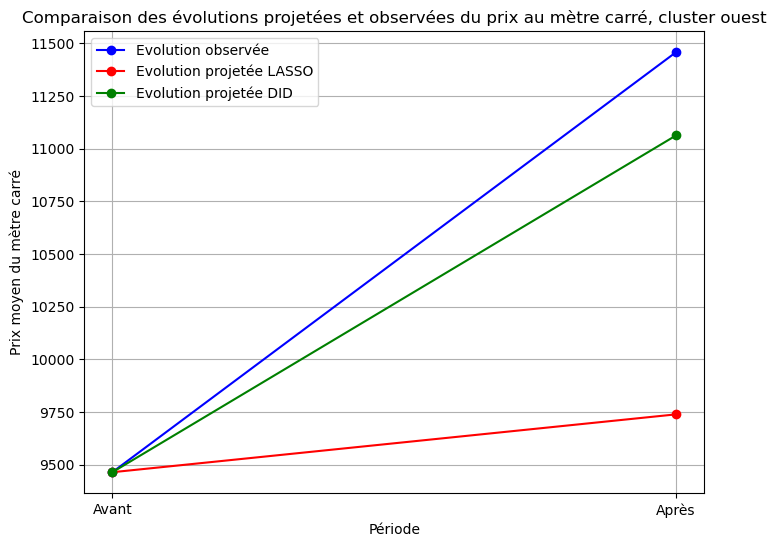

In [100]:
periode = ['Avant', 'Après']
dprt = df_lasso_ouest['prix_m2'].mean()
p1 = list_val_ouest[2]
s1 = list_val_ouest[0]
s2 = list_val_ouest[1]

# Création du graphique
plt.figure(figsize=(8, 6))

# Tracer les valeurs du groupe 1
plt.plot(periode, [dprt, Y_new_obs ], marker='o', label='Evolution observée', color='blue')

# Tracer les valeurs du groupe 2
plt.plot(periode, [dprt, Y_new[0]], marker='o', label='Evolution projetée LASSO', color='red')
plt.plot(periode, [dprt, p1 + (s2 - s1)], marker='o', label='Evolution projetée DID', color='green')


# Ajouter des labels et un titre
plt.xlabel('Période')
plt.ylabel('Prix moyen du mètre carré')
plt.title('Comparaison des évolutions projetées et observées du prix au mètre carré, cluster ouest')
plt.legend()

# Afficher le graphique
plt.grid(True)
plt.show()


On va réaliser le même procédé pour le cluster sud. 

In [101]:
data_mut_sud_et_insee['prix_m2'] = data_mut_sud_et_insee['valeurfonc'] / data_mut_sud_et_insee['stot']
data_mut_sud_et_insee['prop_h'] = data_mut_sud_et_insee['P_H1564'] / data_mut_sud_et_insee['P_POP1564']
data_mut_sud_et_insee['tx_chom'] = data_mut_sud_et_insee['P_CHOM1564'] / data_mut_sud_et_insee['P_ACT1564']
data_mut_sud_et_insee['prop_ht_diplome'] = data_mut_sud_et_insee['C_ACT1564_CS3'] / data_mut_sud_et_insee['P_ACT1564']
data_mut_sud_et_insee['prop_maison'] = data_mut_sud_et_insee['P_MAISON'] / data_mut_sud_et_insee['P_LOG']
data_mut_sud_et_insee['prop_res_princ'] = data_mut_sud_et_insee['P_RP'] / data_mut_sud_et_insee['P_LOG']

list_covar = ['prop_h', 'tx_chom',"prop_ht_diplome", "prop_maison", "prop_res_princ"]

In [102]:
data_mut_sud_et_insee = data_mut_sud_et_insee[data_mut_sud_et_insee['DISP_MED'].apply(est_un_nombre)]
data_mut_sud_et_insee['DISP_MED'] = data_mut_sud_et_insee['DISP_MED'].astype(float)
data_mut_sud_et_insee = data_mut_sud_et_insee.dropna(subset=['DISP_MED'])

In [103]:
df_lasso_sud = data_mut_sud_et_insee[data_mut_sud_et_insee['periode']==0]
df_lasso_sud = df_lasso_sud[df_lasso_sud['coddep']=='75']
X = df_lasso_sud[list_covar+['DISP_MED']]
Y = df_lasso_sud['prix_m2']

In [105]:
df_new_obs = data_mut_sud_et_insee[data_mut_sud_et_insee['periode']==1]
df_new_obs = df_new_obs[df_new_obs['coddep']=='75']
X_new = pd.DataFrame(df_new_obs[list_covar+['DISP_MED']].mean()).T
Y_new_obs = df_new_obs['prix_m2'].mean()

In [106]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [107]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_new_scaled = scaler.transform(X_new)

In [112]:
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, Y_train)

LassoCV(cv=5, random_state=42)

In [113]:
print(lasso_cv.score(X_test_scaled, Y_test))

0.04574369805843892


In [114]:
Y_new = lasso_cv.predict(X_new_scaled)
print(Y_new)
print(Y_new_obs)

[9027.42005385]
10464.034304614761


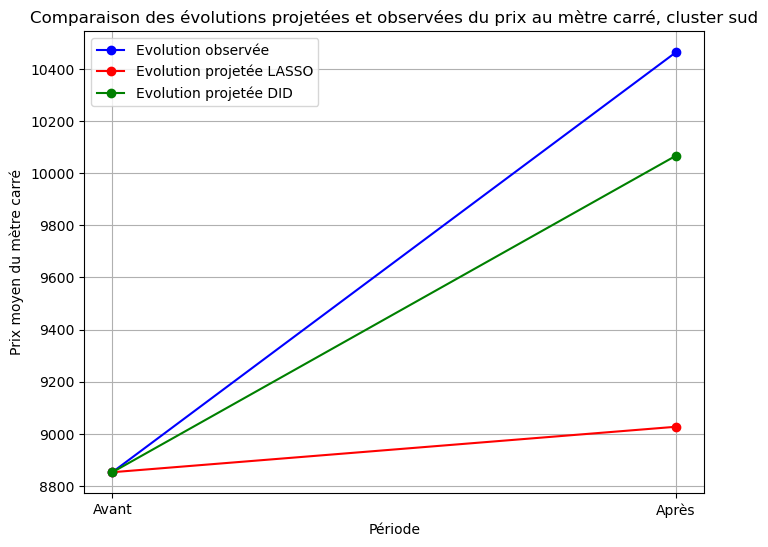

In [115]:
periode = ['Avant', 'Après']
dprt = df_lasso_sud['prix_m2'].mean()
p1 = list_val_sud[2]
s1 = list_val_sud[0]
s2 = list_val_sud[1]


# Création du graphique
plt.figure(figsize=(8, 6))

# Tracer les valeurs du groupe 1
plt.plot(periode, [dprt, Y_new_obs ], marker='o', label='Evolution observée', color='blue')

# Tracer les valeurs du groupe 2
plt.plot(periode, [dprt, Y_new[0]], marker='o', label='Evolution projetée LASSO', color='red')
plt.plot(periode, [dprt, p1 + (s2 - s1)], marker='o', label='Evolution projetée DID', color='green')


# Ajouter des labels et un titre
plt.xlabel('Période')
plt.ylabel('Prix moyen du mètre carré')
plt.title('Comparaison des évolutions projetées et observées du prix au mètre carré, cluster sud')
plt.legend()

# Afficher le graphique
plt.grid(True)
plt.show()


# Conclusion

A partir du modèle différence in difference, on obtient donc que l'encadrement des loyers conduirait à une accélération de la hausse du prix du mètre carré. Ce résultat n'est probablement pas souhaité par le législateur ayant décidé de l'encadrement de loyer, mais n'est pas absurde d'un point de vue économique : certaines études économiques, comme celle de Grégory Verdugo, chercheur associé à l'OFCE ont en effet suggéré que l'encadrement des loyers pourrait être à l'origine d'une baisse l'offre de logements disponibles, ce qui peut avoir deux conséquences : 

- le loyer moyen augmente (soit par non-respect de l'encadrement des loyers, soit par une hausse des loyers qui se situaient en dessous du plafond), ce qui encourage à investir plus dans l'immobilier dans la zone, et donc mène à une hausse des prix du mètre carré ; 
- face au rationnement de l'offre locative, les ménages souhaitant s'installer dans la zone se redirigent vers l'achat, conduisant à une hausse du prix du mètre carré. 

Il s'agît là de deux pistes d'explications, qu'il faudrait explorer. 

Nos résultats ne permettent pas nécessairement de mesurer le véritable impact de cette loi sur le prix de l'immobilier. On suggérera cependant comme explication à la faiblesse de nos résultats les éléments suivants :
- nos régressions utilisent les caractéristiques du quartier et non du bien lui-même ; or la quantité de travaux, le nombre de pièces ou encore l'étage du logement sont des caractéristiques individuelles pouvant expliquer des variations importantes du prix d'un bien immobilier.
- la technique du DID fonctionne bien lorsqu'il y a une rupture nette ; or ici, l'entrée en vigueur de l'encadrement des loyers a pu être anticipée par les acquéreurs potentiels, d'où une absence d'effet visible de la législation autour de 2019. 
- enfin, l'encadrement des loyers n'est pas respecté par tous les propriétaires louant leur appartement : on peut aussi supposer que cette régulation n'a pas eu d'effet sur les prix de l'immobilier car les investisseurs savaient qu'ils pourraient louer leur bien à un prix supérieur à celui de l'encadrement des loyers. 